# Financial Portfolio Analysis

### Download libraries

In [ ]:
!pip install yfinance pandas numpy matplotlib seaborn PyPortfolioOpt

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from copy import deepcopy
import itertools
from pypfopt import risk_models, expected_returns
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import plotting

# Global settings
sns.set_theme(style="darkgrid")
plt.rcParams['figure.figsize'] = (14, 7)
pd.set_option('display.max_columns', 10)
pd.set_option('display.width', 1000)


## Setup

In [ ]:
import numpy as np
import pandas as pd
id_student = 11230967
csv_path = "stock_close_prices.csv"
df_close = pd.read_csv(csv_path, index_col=0, parse_dates=True)
np.random.seed(id_student)
assets = np.random.choice(df_close.columns, size=5, replace=False)
print(f"Selected portfolio: {assets}")

Selected portfolio: ['META' 'GOOGL' 'WMT' 'NVDA' 'MSFT']


In [ ]:
# =============================================================================
# SETTINGS
# =============================================================================

all_tickers = assets

YEARS_OF_DATA = 5
SMA_WINDOWS = [50, 200]
ROLLING_VOL_WINDOW = 21
ROLLING_CORR_WINDOW = 60
PLOT_LAST_N_DAYS = 500  # For clarity in plots
risk_free_rate = 0.02
TRAIN_ROWS = 504

start_date_total = str(df_close.index[0].date())                 # first date in dataset
end_date_total   = str(df_close.index[-1].date())                # last date in dataset
split_date       = str(df_close.index[TRAIN_ROWS - 1].date())    # last date of training set

# Date configuration
START_DATE = start_date_total
END_DATE = end_date_total
SPLIT_DATE = split_date

# Parameters
RISK_FREE_RATE = 0.02  # 2% annual risk-free rate
WEIGHT_BOUNDS = (0, 1)  # Allow long-only positions (0% to 100% per asset)

## 1. Exploratory Analysis

### 1.1. Defining functions

#### 1.1.1. Load data

Load historical price data (closing prices) for the list of tickers over the years.

In [ ]:
# =============================================================================
# LOAD DATA
# =============================================================================
# =============================================================================
# LOAD DATA FROM CSV - PART 1
# =============================================================================

def load_intro_data_from_csv(csv_path, tickers=None):
    """
    Load data from CSV file instead of Yahoo Finance

    CHANGE: Reads from csv_path instead of yf.download()

    Parameters:
    - csv_path: Path to CSV file
    - tickers: Optional list to filter specific tickers (if None, loads all)

    CSV Format Expected:
    - First column: Date (will become index)
    - Other columns: Ticker prices (e.g., AAPL, MSFT, GOOGL, SPY)
    """
    print(f"Loading data from CSV: {csv_path}")

    try:
        # CHANGE: Read from CSV instead of yf.download()
        data = pd.read_csv(csv_path, index_col=0, parse_dates=True)

        # Filter tickers if specified
        if tickers is not None:
            # Check which tickers are available
            available_tickers = [t for t in tickers if t in data.columns]
            missing_tickers = set(tickers) - set(available_tickers)

            if missing_tickers:
                print(f"⚠️  Warning: Missing tickers in CSV: {missing_tickers}")

            if not available_tickers:
                raise ValueError(f"None of the requested tickers found in CSV: {tickers}")

            # Select only requested tickers
            data = data[available_tickers]
            print(f"Selected tickers: {available_tickers}")

        # SAME: Clean data (forward fill and drop NaN)
        data = data.ffill().dropna()

        if data.empty:
            raise ValueError("No data after cleaning. Check CSV file.")

        print(f"✓ Data loaded successfully")
        print(f"  Period: {data.index.min().date()} → {data.index.max().date()}")
        print(f"  Days: {len(data)}")
        print(f"  Tickers: {list(data.columns)}")
        print()

        return data

    except Exception as e:
        print(f"✗ ERROR: {e}")
        return None


# CHANGE: Use CSV path instead of yf.download
intro_data = load_intro_data_from_csv(csv_path, tickers=all_tickers)

Loading data from CSV: stock_close_prices.csv
Selected tickers: ['META', 'GOOGL', 'WMT', 'NVDA', 'MSFT']
✓ Data loaded successfully
  Period: 2023-09-01 → 2025-11-26
  Days: 562
  Tickers: ['META', 'GOOGL', 'WMT', 'NVDA', 'MSFT']



#### 1.1.2. Timezone management

Timezone conversion ensures that all price data aligns to a consistent, correct timeline—crucial when analyzing any tickers from different global markets. Without it, assets from the U.S., Europe, and Asia appear to trade at mismatched hours, causing misaligned returns, incorrect daily signals, distorted correlations, and broken backtests. By converting everything into one timezone (e.g., your local Vietnam time), the dataset becomes synchronized, enabling accurate portfolio optimization, risk calculations, and trading strategy generation. Even if not strictly required, including this step helps you understand real-world financial data handling and produces cleaner, more reliable results.

In [ ]:
# =============================================================================
# TIMEZONE MANAGEMENT
# =============================================================================
def convert_timezone(df, from_tz='America/New_York', to_tz='Asia/Ho_Chi_Minh'):
    """Localize and convert timezone"""
    df_local = df.tz_localize(from_tz, ambiguous='infer')
    df_converted = df_local.tz_convert(to_tz)
    return df_converted

# Optional: intro_data_tz = convert_timezone(intro_data)

#### 1.1.3. Resampling

This function resamples the price data into a lower frequency—typically from daily prices to monthly prices. Resampling is important because many portfolio optimization models work better with lower-frequency data, and many trading strategies also rely on weekly/monthly bars.

In [ ]:
# =============================================================================
# DOWNSAMPLING & RESAMPLING
# =============================================================================
def resample_data(df, freq='M', method='last'):
    """Resample data to monthly or weekly frequency"""
    if method == 'ohlc':
        return df.resample(freq).ohlc()
    else:
        return df.resample(freq).last()

# Example usage:
# aapl_monthly = resample_data(intro_data[['AAPL']], freq='M')
# aapl_weekly_ohlc = resample_data(intro_data[['AAPL']], freq='W', method='ohlc')

#### 1.1.4. Calculating returns

This function takes a price series for one ticker and computes two types of returns: simple returns and log returns, both of which are essential inputs for portfolio optimization, risk analysis, and trading strategy signals.

In [ ]:
# =============================================================================
# RETURNS CALCULATION
# =============================================================================
def calculate_returns(df):
    df = df.copy()
    ticker_name = df.columns[0]
    df['Returns_Simple'] = df[ticker_name].pct_change()
    df['Returns_Log'] = np.log(df[ticker_name] / df[ticker_name].shift(1))
    return df.dropna()


#### 1.1.5. Calculating SMAs

This function computes Simple Moving Averages (SMAs) for a price series over multiple window lengths. SMAs are core technical indicators used in many trading strategies, especially trend-following and crossover systems.

In [ ]:
# =============================================================================
# SIMPLE MOVING AVERAGE
# =============================================================================
def calculate_sma(df, windows=SMA_WINDOWS):
    sma_df = df.copy()
    for w in windows:
        sma_df[f'SMA{w}'] = df.rolling(window=w).mean()
    return sma_df

#### 1.1.6. Calculating volitility

This function computes rolling (moving) volatility of a ticker using its log returns, scaled to annualized volatility, which is a key metric for risk analysis and portfolio optimization.

In [ ]:
# =============================================================================
# ROLLING VOLATILITY
# =============================================================================
def calculate_rolling_volatility(df, window=ROLLING_VOL_WINDOW):
    return df['Returns_Log'].rolling(window=window).std() * np.sqrt(252)

#### 1.1.7. Calculatinng correlation

This function computes the rolling correlation between two tickers based on their log returns, over a specified rolling window. Rolling correlation measures how closely two assets move together over time, which is crucial for portfolio diversification and risk management.

In [ ]:
# =============================================================================
# ROLLING CORRELATION
# =============================================================================
def calculate_rolling_correlation(df, ticker1, ticker2, window=ROLLING_CORR_WINDOW):
    returns1 = np.log(df[ticker1] / df[ticker1].shift(1))
    returns2 = np.log(df[ticker2] / df[ticker2].shift(1))
    return returns1.rolling(window=window).corr(returns2).dropna()

#### 1.1.8. Visualization

These functions generate plots for prices, technical indicators, volatility, and rolling correlations. Visualization is crucial for quickly interpreting trends, risk, and relationships between assets, making the analysis more understandable and actionable.

In [ ]:
# =============================================================================
# AUTOMATED VISUALIZATION
# =============================================================================
def plot_price_and_indicators(df, sma_windows=SMA_WINDOWS, last_n=PLOT_LAST_N_DAYS):
    """Plot price + SMAs for the last N days"""
    plt.figure(figsize=(14, 7))
    plt.plot(df.index[-last_n:], df.iloc[-last_n:, 0], label='Price', linewidth=2)
    for col in df.columns:
        if 'SMA' in col:
            plt.plot(df.index[-last_n:], df[col].iloc[-last_n:], label=col, linewidth=1.5)
    plt.title(f'{df.columns[0]} Price with SMA')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def plot_volatility(volatility, last_n=PLOT_LAST_N_DAYS):
    plt.figure(figsize=(14, 6))
    plt.plot(volatility.index[-last_n:], volatility.iloc[-last_n:], color='darkred', linewidth=2)
    plt.title('Rolling Volatility (Annualized)')
    plt.xlabel('Date')
    plt.ylabel('Volatility')
    plt.grid(True, alpha=0.3)
    plt.show()

def plot_rolling_correlation(rolling_corr, mean_corr=None, last_n=PLOT_LAST_N_DAYS):
    plt.figure(figsize=(14, 6))
    plt.plot(rolling_corr.index[-last_n:], rolling_corr.iloc[-last_n:], color='purple', linewidth=2)
    if mean_corr is None:
        mean_corr = rolling_corr.mean()
    plt.axhline(mean_corr, color='red', linestyle='--', label=f'Average ({mean_corr:.2f})')
    plt.title('Rolling Correlation')
    plt.xlabel('Date')
    plt.ylabel('Correlation')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

### 1.2. Code execution


TICKER: META
Latest Price: $633.61
Price change over period: 115.10% → Trend is upward
Annualized Return: 34.41% → Performance is strong
Annualized Volatility: 35.95% → Risk level is moderate
Short-term trend (50-day SMA) is above long-term trend (200-day SMA) → Bullish signal


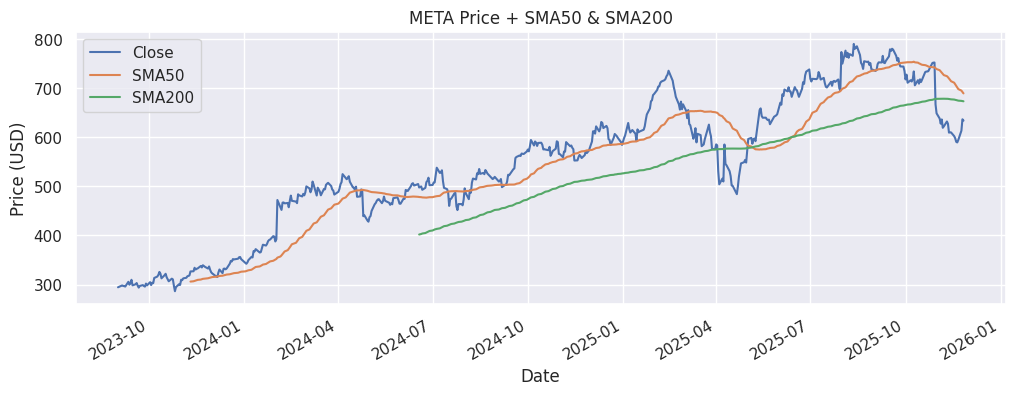

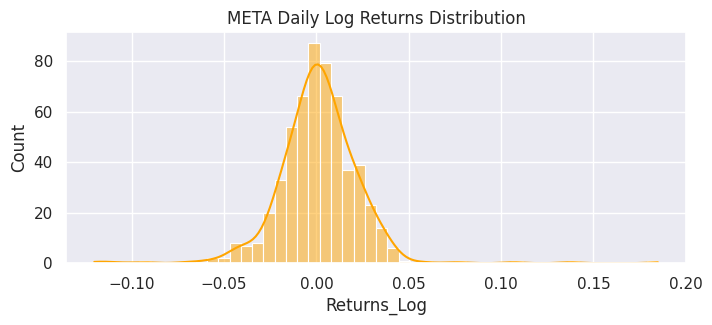


TICKER: GOOGL
Latest Price: $319.95
Price change over period: 137.47% → Trend is upward
Annualized Return: 38.85% → Performance is strong
Annualized Volatility: 30.12% → Risk level is moderate
Short-term trend (50-day SMA) is above long-term trend (200-day SMA) → Bullish signal


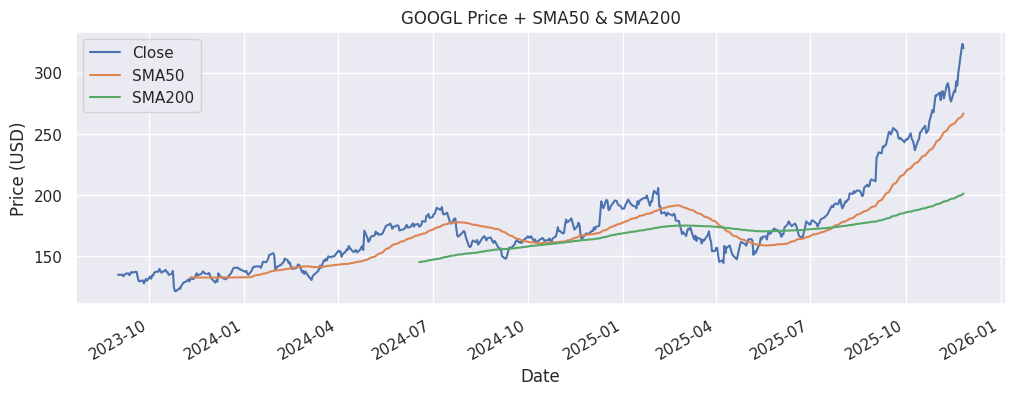

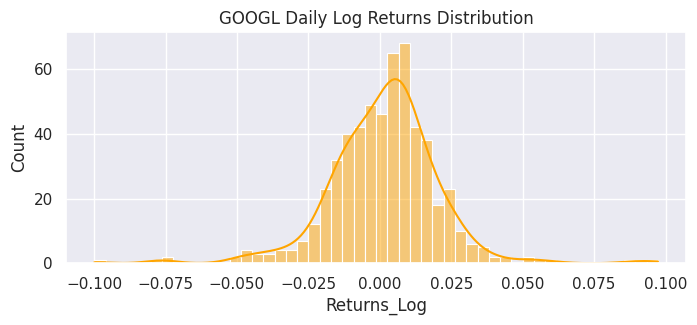


TICKER: WMT
Latest Price: $109.10
Price change over period: 107.31% → Trend is upward
Annualized Return: 32.75% → Performance is strong
Annualized Volatility: 21.47% → Risk level is moderate
Short-term trend (50-day SMA) is above long-term trend (200-day SMA) → Bullish signal


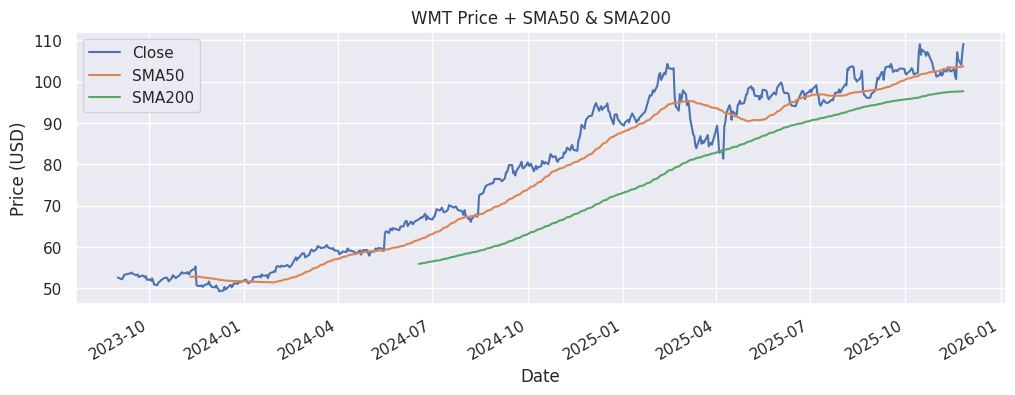

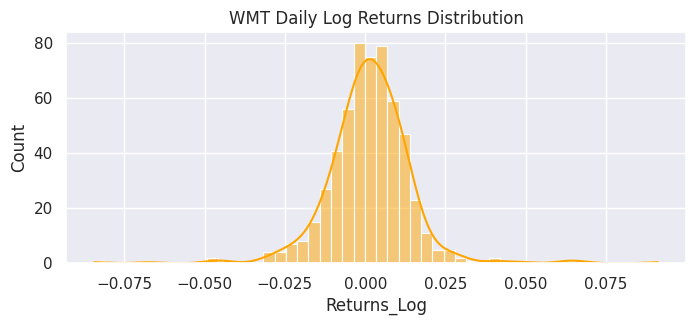


TICKER: NVDA
Latest Price: $180.26
Price change over period: 271.85% → Trend is upward
Annualized Return: 58.99% → Performance is strong
Annualized Volatility: 49.42% → Risk level is high
Short-term trend (50-day SMA) is above long-term trend (200-day SMA) → Bullish signal


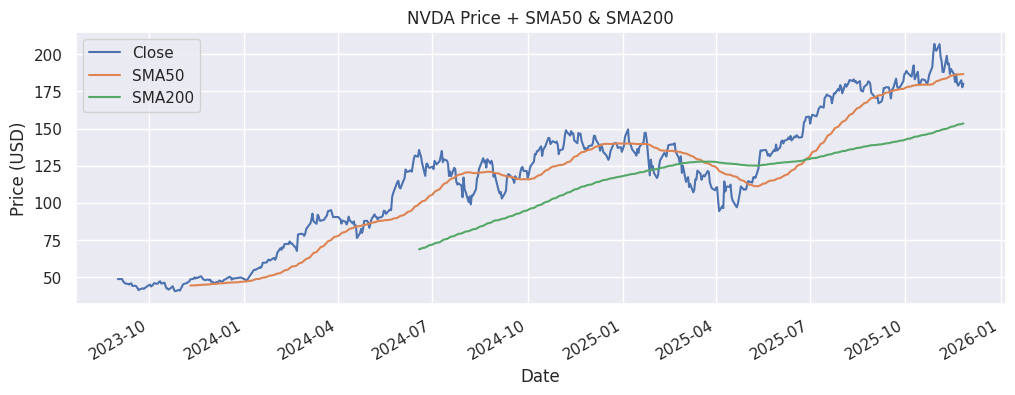

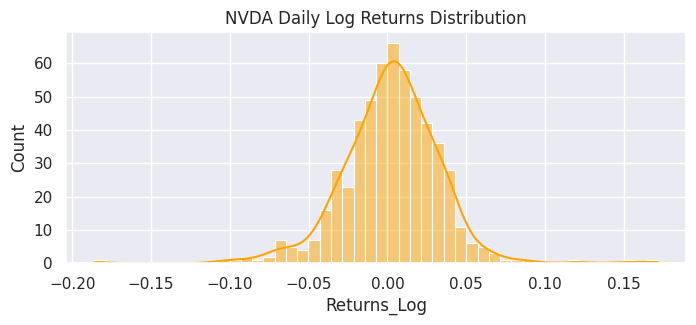


TICKER: MSFT
Latest Price: $485.50
Price change over period: 50.23% → Trend is upward
Annualized Return: 18.28% → Performance is strong
Annualized Volatility: 22.04% → Risk level is moderate
Short-term trend (50-day SMA) is above long-term trend (200-day SMA) → Bullish signal


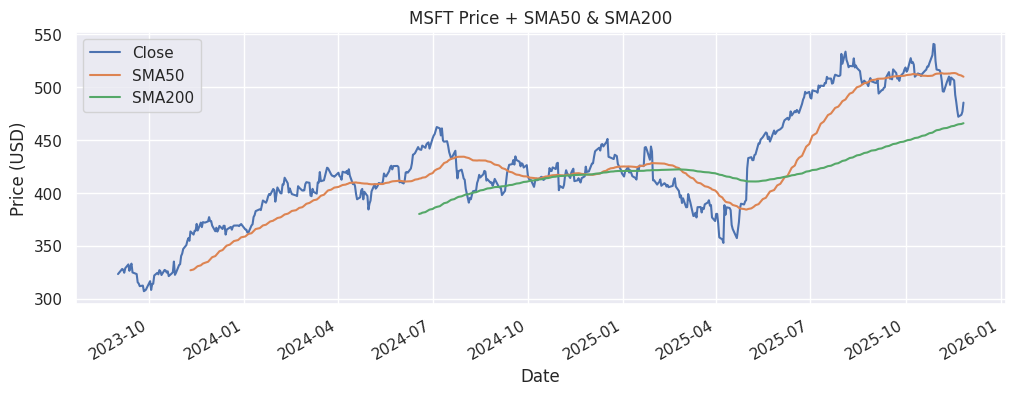

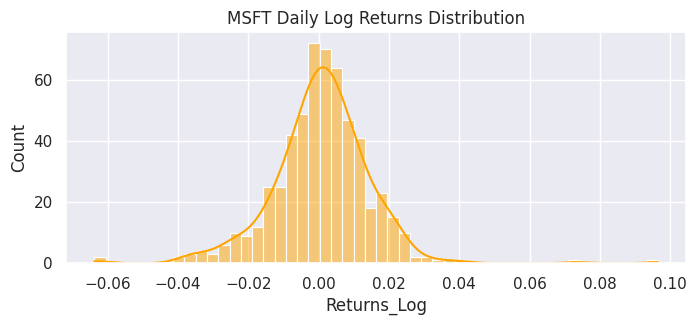

In [ ]:
# =============================================================================
# EXPLORATORY ANALYSIS FOR ALL TICKERS
# =============================================================================
for ticker in intro_data.columns:
    print(f"\n{'='*60}\nTICKER: {ticker}\n{'='*60}")

    # Prepare DataFrame with standardized column name
    df = intro_data[[ticker]].copy()
    df = df.rename(columns={ticker: 'Close'})

    # --- Calculate returns ---
    returns_df = calculate_returns(df)

    # Ensure 'Returns_Log' exists
    if isinstance(returns_df, pd.Series):
        returns_df = returns_df.to_frame(name='Returns_Log')
    elif 'Returns_Log' not in returns_df.columns:
        if 'Log' in returns_df.columns:
            returns_df = returns_df.rename(columns={'Log': 'Returns_Log'})
        else:
            print(f"WARNING: Returns_Log not found for {ticker}. Skipping this ticker.")
            continue

    # --- Calculate rolling volatility ---
    # FIX: Pass the entire DataFrame, not just the Series
    vol = calculate_rolling_volatility(returns_df)

    # --- Calculate SMAs ---
    sma_df = calculate_sma(df)

    # --- Basic metrics ---
    latest_price = df['Close'].iloc[-1]
    price_change_pct = (df['Close'].iloc[-1] / df['Close'].iloc[0] - 1) * 100
    avg_annual_return = returns_df['Returns_Log'].mean() * 252  # Annualized
    annual_vol = returns_df['Returns_Log'].std() * np.sqrt(252)

    # --- Trend analysis ---
    trend = (
        "upward" if price_change_pct > 5
        else "downward" if price_change_pct < -5
        else "sideways"
    )

    # --- Risk/Return analysis ---
    risk_level = (
        "low" if annual_vol < 0.2
        else "moderate" if annual_vol < 0.4
        else "high"
    )
    return_comment = (
        "strong" if avg_annual_return > 0.15
        else "moderate" if avg_annual_return > 0
        else "weak"
    )

    # --- Print textual analysis ---
    print(f"Latest Price: ${latest_price:.2f}")
    print(f"Price change over period: {price_change_pct:.2f}% → Trend is {trend}")
    print(f"Annualized Return: {avg_annual_return:.2%} → Performance is {return_comment}")
    print(f"Annualized Volatility: {annual_vol:.2%} → Risk level is {risk_level}")

    # --- SMA trend comment ---
    if sma_df['SMA50'].iloc[-1] > sma_df['SMA200'].iloc[-1]:
        print("Short-term trend (50-day SMA) is above long-term trend (200-day SMA) → Bullish signal")
    else:
        print("Short-term trend (50-day SMA) is below long-term trend (200-day SMA) → Bearish signal")

    # --- Simple plots ---
    sma_df[['Close','SMA50','SMA200']].plot(
        title=f'{ticker} Price + SMA50 & SMA200', figsize=(12,4)
    )
    plt.ylabel('Price (USD)')
    plt.show()

    plt.figure(figsize=(8,3))
    sns.histplot(returns_df['Returns_Log'], bins=50, kde=True, color='orange')
    plt.title(f'{ticker} Daily Log Returns Distribution')
    plt.show()

## 2. Portfolio Optimization

### 2.1. Defining functions

#### 2.1.1. Load data

Handling data retrieval, cleaning, and splitting for portfolio optimization. It produces train and test datasets, which are essential for backtesting portfolio optimization strategies.

In [ ]:
# =============================================================================
# DATA LOADING & SPLITTING FROM CSV - PART 2
# =============================================================================

def load_and_split_portfolio_data_from_csv(csv_path, tickers, start_date, end_date, split_date):

    n = len(tickers)

    print(f"\n{'='*80}")
    print("PART 2: PORTFOLIO OPTIMIZATION - DATA LOADING FROM CSV")
    print(f"{'='*80}")
    print(f"CSV File: {csv_path}")
    print(f"Tickers: {tickers} (n={n})")
    print(f"Period: {start_date} to {end_date}")
    print(f"Train/Test Split: {split_date}")

    try:
        # CHANGE: Read from CSV instead of yf.download()
        print("\nReading data from CSV...")
        full_data = pd.read_csv(csv_path, index_col=0, parse_dates=True)

        # CHANGE: Filter by date range
        full_data = full_data.loc[start_date:end_date]

        # CHANGE: Select only requested tickers
        available_tickers = [t for t in tickers if t in full_data.columns]
        missing_tickers = set(tickers) - set(available_tickers)

        if missing_tickers:
            raise ValueError(f"Missing tickers in CSV: {missing_tickers}")

        full_data = full_data[tickers]

        # Handle single ticker case (SAME AS ORIGINAL)
        if isinstance(full_data, pd.Series):
            full_data = full_data.to_frame(name=tickers[0])

        # SAME: Clean data
        full_data = full_data.ffill().dropna()

        if full_data.empty:
            raise ValueError("No data after filtering and cleaning. Check CSV and date range.")

        # SAME: Validate all tickers present
        missing = set(tickers) - set(full_data.columns)
        if missing:
            raise ValueError(f"Missing data for tickers: {missing}")

        # SAME: Split into train/test
        train_data = full_data.loc[:split_date]
        test_data = full_data.loc[split_date:].iloc[1:]  # Skip first day to avoid overlap

        # SAME: Validate split
        if train_data.empty or test_data.empty:
            raise ValueError("Train or test set is empty. Check split date.")

        print(f"\n✓ Data loaded successfully from CSV")
        print(f"  Total: {len(full_data)} days")
        print(f"  Train: {train_data.index.min().date()} to {train_data.index.max().date()} ({len(train_data)} days)")
        print(f"  Test:  {test_data.index.min().date()} to {test_data.index.max().date()} ({len(test_data)} days)")

        return full_data, train_data, test_data, n

    except Exception as e:
        print(f"\n✗ ERROR: {e}")
        raise


full_data, train_data, test_data, n = load_and_split_portfolio_data_from_csv(
    csv_path,
    all_tickers,
    START_DATE,
    END_DATE,
    SPLIT_DATE
)



PART 2: PORTFOLIO OPTIMIZATION - DATA LOADING FROM CSV
CSV File: stock_close_prices.csv
Tickers: ['META' 'GOOGL' 'WMT' 'NVDA' 'MSFT'] (n=5)
Period: 2023-09-01 to 2025-11-26
Train/Test Split: 2025-09-05

Reading data from CSV...

✓ Data loaded successfully from CSV
  Total: 562 days
  Train: 2023-09-01 to 2025-09-05 (504 days)
  Test:  2025-09-08 to 2025-11-26 (58 days)


#### 2.1.2. Computing key inputs for portfolio

Computing key inputs for portfolio optimization using the training dataset: expected returns, the covariance matrix, and individual asset metrics like volatility and Sharpe ratio. These inputs are essential for constructing and evaluating efficient portfolios.
- mu – expected annual return of each asset; shows how much return you can anticipate from that asset in a year.

- S – covariance matrix of asset returns; shows how assets move together and quantifies portfolio risk.

- individual_vol – annualized volatility of each asset; measures how much the asset’s returns fluctuate (risk).

- individual_sharpe – Sharpe ratio of each asset; shows risk-adjusted return, indicating return per unit of risk.

In [ ]:
# =============================================================================
# PORTFOLIO INPUTS CALCULATION
# =============================================================================

def calculate_portfolio_inputs(train_data, tickers, risk_free_rate):
    """
    Calculates expected returns and covariance matrix

    GENERALIZATION: Works with any tickers
    OPTIMIZATION: Pre-calculates individual metrics for k-of-n search
    """
    print(f"\n{'='*80}")
    print("CALCULATING PORTFOLIO INPUTS (Train Set)")
    print(f"{'='*80}")

    # Expected returns (annualized)
    mu = expected_returns.mean_historical_return(train_data, frequency=252)

    # Covariance matrix (annualized)
    S = risk_models.sample_cov(train_data, frequency=252)

    # Pre-calculate individual asset metrics (for efficiency in k-of-n)
    individual_vol = pd.Series(np.sqrt(np.diag(S)), index=tickers)
    individual_sharpe = (mu - risk_free_rate) / individual_vol

    print(f"✓ Inputs calculated for {len(mu)} assets")
    print("\n--- Expected Annual Returns ---")
    print(mu.sort_values(ascending=False).apply(lambda x: f"{x:.2%}"))
    print("\n--- Annualized Volatilities ---")
    print(individual_vol.sort_values().apply(lambda x: f"{x:.2%}"))

    return {
        'mu': mu,
        'S': S,
        'individual_vol': individual_vol.to_dict(),
        'individual_sharpe': individual_sharpe.to_dict()
    }


#### 2.1.3. Asset optimization

The optimize_n_assets() function outputs two main results: cleaned_weights and perf.
- The cleaned_weights dictionary contains the optimal allocation for each asset in the portfolio, with each number representing the fraction of total capital to invest in that asset according to the chosen optimization objective.
- The perf tuple provides three key portfolio performance metrics: the first element is the expected annual portfolio return, representing the weighted return based on the optimal allocation; the second element is the expected annual portfolio volatility, which measures the overall risk of the portfolio while accounting for correlations between assets; and the third element is the portfolio Sharpe ratio, indicating the risk-adjusted return and showing how much return the portfolio generates per unit of risk.

Together, these outputs describe both the optimal composition of the portfolio and its anticipated performance, serving as the foundation for evaluating, comparing, and implementing portfolio strategies.

In [ ]:
# =============================================================================
# N-ASSET OPTIMIZATION (ALL ASSETS)
# =============================================================================

def optimize_n_assets(mu, S, objective='max_sharpe', risk_free_rate=0.02,
                      weight_bounds=(0, 1)):
    """
    Optimizes portfolio using all n assets

    GENERALIZATION: Works with any n
    OPTIMIZATION: Unified function for both objectives
    """
    obj_name = "Max Sharpe" if objective == 'max_sharpe' else "Min Volatility"

    print(f"\n{'='*80}")
    print(f"N-ASSET OPTIMIZATION: {obj_name} (Train Set)")
    print(f"{'='*80}")

    try:
        # Initialize optimizer
        ef = EfficientFrontier(mu, S, weight_bounds=weight_bounds)

        # Optimize based on objective
        if objective == 'max_sharpe':
            ef.max_sharpe(risk_free_rate=risk_free_rate)
        else:
            ef.min_volatility()

        # Get results
        cleaned_weights = ef.clean_weights()
        perf = ef.portfolio_performance(verbose=False, risk_free_rate=risk_free_rate)

        print(f"\n✓ Optimization successful")
        print(f"\nOptimal Weights:")
        weights_series = pd.Series(cleaned_weights)
        weights_series = weights_series[weights_series > 0.001].sort_values(ascending=False)
        for ticker, weight in weights_series.items():
            print(f"  {ticker}: {weight:.2%}")

        print(f"\nExpected Performance:")
        print(f"  Annual Return: {perf[0]:.2%}")
        print(f"  Annual Volatility: {perf[1]:.2%}")
        print(f"  Sharpe Ratio: {perf[2]:.3f}")

        # Visualize
        fig, ax = plt.subplots(figsize=(8, 8))
        non_zero_weights = weights_series[weights_series > 0.001]
        if not non_zero_weights.empty:
            non_zero_weights.plot.pie(ax=ax, autopct='%1.1f%%', startangle=90)
            ax.set_title(f'n-Asset Weights ({obj_name}) - Train Set',
                        fontsize=14, fontweight='bold')
            ax.set_ylabel('')
            plt.tight_layout()
            plt.show()

        return cleaned_weights, perf

    except Exception as e:
        print(f"\n✗ Optimization failed: {e}")
        return None, None


#### 2.1.4. k-of-n asset optimization

The search_k_of_n_portfolios() function searches all possible subsets of the given tickers to find the optimal portfolio for maximizing Sharpe ratio or minimizing volatility. It uses pre-calculated returns, covariance, and individual metrics to speed up single-asset evaluations and runs full optimization for larger subsets. The function tracks each subset’s return, volatility, and Sharpe ratio, and returns the best_weights for the optimal portfolio along with a results_df of all tested combinations. It also prints key results and visualizes the optimal allocation.


In [ ]:
# =============================================================================
# K-OF-N OPTIMIZATION (SUBSET SEARCH)
# =============================================================================

def search_k_of_n_portfolios(tickers, portfolio_inputs, objective='max_sharpe',
                             risk_free_rate=0.02, weight_bounds=(0, 1),
                             k_max=None):
    """
    Searches all possible k-of-n combinations.

    k_max: user-defined max subset size.
           If None -> uses full n (default original behavior).
    """
    n = len(tickers)

    # If user does not specify k_max → default to n
    if k_max is None:
        k_max = n

    # Safety: cap k_max at n
    k_max = min(k_max, n)

    obj_name = "Max Sharpe" if objective == 'max_sharpe' else "Min Volatility"

    print(f"\n{'='*80}")
    print(f"K-OF-N SEARCH: {obj_name} (Train Set)")
    print(f"{'='*80}")
    print(f"Searching all combinations for k = 1 to k = {k_max} (n = {n})")

    mu = portfolio_inputs['mu']
    S = portfolio_inputs['S']
    individual_vol = portfolio_inputs['individual_vol']
    individual_sharpe = portfolio_inputs['individual_sharpe']

    # Initialize tracking
    best_metric = -np.inf if objective == 'max_sharpe' else np.inf
    best_weights = None
    all_results = []

    # Iterate through k = 1 … k_max
    for k in range(1, k_max + 1):
        combinations = list(itertools.combinations(tickers, k))
        print(f"\nk={k}: Testing {len(combinations)} combinations...")

        for combo in combinations:
            combo_list = list(combo)

            try:
                # Fast path for k=1
                if k == 1:
                    ticker = combo_list[0]
                    ret = mu[ticker]
                    vol = individual_vol[ticker]
                    sharpe = individual_sharpe[ticker]
                    weights = {ticker: 1.0}

                # Optimization for k>1
                else:
                    mu_combo = mu[combo_list]
                    S_combo = S.loc[combo_list, combo_list]
                    ef = EfficientFrontier(mu_combo, S_combo, weight_bounds=weight_bounds)

                    if objective == 'max_sharpe':
                        ef.max_sharpe(risk_free_rate=risk_free_rate)
                    else:
                        ef.min_volatility()

                    ret, vol, sharpe = ef.portfolio_performance(risk_free_rate=risk_free_rate)
                    weights = ef.clean_weights()

                # Compare result
                current_metric = sharpe if objective == 'max_sharpe' else vol
                is_better = (objective == 'max_sharpe' and current_metric > best_metric) or \
                            (objective == 'min_volatility' and current_metric < best_metric)

                if is_better:
                    best_metric = current_metric
                    best_weights = weights

                # Save result
                all_results.append({
                    'k': k,
                    'Combination': ', '.join(combo_list),
                    'Return': ret,
                    'Volatility': vol,
                    'Sharpe': sharpe,
                    'Weights': weights
                })

            except:
                continue

    # Convert to DataFrame
    results_df = pd.DataFrame(all_results)
    if objective == 'max_sharpe':
        results_df = results_df.sort_values('Sharpe', ascending=False)
    else:
        results_df = results_df.sort_values('Volatility', ascending=True)
    results_df = results_df.reset_index(drop=True)

    # Print results
    print(f"\n{'='*80}")
    print("✓ SEARCH COMPLETE")
    print(f"{'='*80}")

    metric_name = "Sharpe" if objective == 'max_sharpe' else "Volatility"
    print(f"\nBest {metric_name}: {best_metric:.4f} (k={len(best_weights)} assets)")
    print("\nOptimal Weights:")
    for ticker, weight in sorted(best_weights.items(), key=lambda x: x[1], reverse=True):
        if weight > 0.001:
            print(f"  {ticker}: {weight:.2%}")

    print("\n--- Top 10 Combinations ---")
    print(results_df[['k', 'Combination', 'Sharpe', 'Volatility']].head(10).to_string(index=False))

    # Pie Chart
    fig, ax = plt.subplots(figsize=(8, 8))
    weights_series = pd.Series(best_weights)
    weights_series = weights_series[weights_series > 0.001]
    if not weights_series.empty:
        weights_series.plot.pie(ax=ax, autopct='%1.1f%%', startangle=90)
        ax.set_title(f'k-of-n Weights ({obj_name}) - Train Set', fontsize=14, fontweight='bold')
        ax.set_ylabel('')
        plt.tight_layout()
        plt.show()

    return best_weights, results_df



#### 2.1.5. Efficient frontier

Generating a visual representation of the efficient frontier for a given set of assets. It manually calculates portfolios across a range of target returns, plotting the corresponding risk (volatility) and return points to form the frontier, which avoids solver errors from built-in plotting methods. Individual assets are plotted as points with their own risk-return positions, and selected optimal portfolios from portfolios_dict are highlighted with distinct markers and colors.

This visualization helps see the trade-off between risk and return, compare individual assets against the frontier, and evaluate how chosen portfolios perform relative to the theoretically optimal set of portfolios for the given number of assets.

In [ ]:
# =============================================================================
# EFFICIENT FRONTIER VISUALIZATION
# =============================================================================

def plot_efficient_frontier_manual(mu, S, portfolios_dict, n_assets, risk_free_rate=0.02):
    """
    Plots efficient frontier manually (avoids solver errors)

    GENERALIZATION: Works with any number of assets
    OPTIMIZATION: Manual plotting is more robust than built-in function
    """
    print(f"\n{'='*80}")
    print("PLOTTING EFFICIENT FRONTIER")
    print(f"{'='*80}")

    fig, ax = plt.subplots(figsize=(12, 7))

    # Manually calculate efficient frontier points
    returns = []
    risks = []
    target_returns = np.linspace(mu.min(), mu.max(), 300)

    for target_ret in target_returns:
        try:
            ef = EfficientFrontier(mu, S, weight_bounds=(0, 1))
            ef.efficient_return(target_ret)
            ret, risk, _ = ef.portfolio_performance()
            returns.append(ret)
            risks.append(risk)
        except:
            continue

    # Plot efficient frontier
    if returns and risks:
        ax.plot(risks, returns, linewidth=2.5, label='Efficient Frontier', color='purple')

    # Plot individual assets
    for ticker in mu.index:
        asset_return = mu[ticker]
        asset_risk = np.sqrt(S.loc[ticker, ticker])
        ax.scatter(asset_risk, asset_return, marker='o', s=100, alpha=0.6)
        ax.text(asset_risk * 1.01, asset_return * 1.01, ticker, fontsize=9)

    # Plot optimal portfolios
    colors = ['red', 'blue', 'green', 'orange']
    markers = ['*', 'X', 'D', 's']

    for i, (name, perf) in enumerate(portfolios_dict.items()):
        ax.scatter(perf[1], perf[0],
                  marker=markers[i % len(markers)],
                  s=300,
                  c=colors[i % len(colors)],
                  edgecolors='black',
                  linewidths=2,
                  label=name,
                  zorder=5)

    ax.set_title(f'Efficient Frontier (n={n_assets} assets) - Train Set',
                fontsize=16, fontweight='bold')
    ax.set_xlabel('Volatility (Risk)', fontsize=12)
    ax.set_ylabel('Expected Return', fontsize=12)
    ax.legend(fontsize=10, loc='best')
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


#### 2.1.6. Backtesting

Evaluating multiple portfolio strategies on out-of-sample data. It calculates daily and cumulative returns for each strategy, including an equal-weight benchmark, and computes key performance metrics such as total return, annualized return, volatility, Sharpe ratio, maximum drawdown, and Calmar ratio. Results are summarized in a table sorted by Sharpe ratio, and performance is visualized through plots of cumulative returns and drawdowns, enabling a comprehensive assessment of each strategy’s risk-adjusted performance.

In [ ]:
# =============================================================================
# BACKTESTING
# =============================================================================

def backtest_all_strategies(test_data, strategies_weights, tickers,
                            risk_free_rate=0.02, initial_capital=1.0):
    """
    Backtests all strategies on out-of-sample data

    GENERALIZATION: Handles any number of strategies and tickers
    OPTIMIZATION: Vectorized operations for speed
    """
    print(f"\n{'='*80}")
    print("BACKTESTING (Out-of-Sample Test Set)")
    print(f"{'='*80}")
    print(f"Test period: {test_data.index.min().date()} to {test_data.index.max().date()}")
    print(f"Test days: {len(test_data)}")

    # Calculate returns
    test_returns = test_data.pct_change().dropna()

    # Store daily returns for each strategy
    portfolio_returns = pd.DataFrame(index=test_returns.index)

    # Add equal-weight benchmark
    n = len(tickers)
    strategies_weights['Benchmark (Equal Weight)'] = {ticker: 1/n for ticker in tickers}

    # Calculate daily returns for each strategy
    for strategy_name, weights in strategies_weights.items():
        strategy_tickers = list(weights.keys())
        weighted_returns = test_returns[strategy_tickers] * pd.Series(weights)
        portfolio_returns[strategy_name] = weighted_returns.sum(axis=1)

    # Cumulative returns starting from initial capital
    cumulative_returns = initial_capital * (1 + portfolio_returns).cumprod()

    # Calculate metrics
    metrics = {}
    for strategy in portfolio_returns.columns:
        metrics[strategy] = calculate_performance_metrics(
            cumulative_returns[strategy],
            risk_free_rate
        )

    metrics_df = pd.DataFrame(metrics).T
    sharpe_col = [c for c in metrics_df.columns if 'sharpe' in c.lower()][0]
    metrics_df = metrics_df.sort_values(sharpe_col, ascending=False)

    print(f"\n--- PERFORMANCE METRICS (Out-of-Sample) ---")
    print(metrics_df.to_string(float_format=lambda x: f"{x:.2%}"))

    # Visualize
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10),
                                   gridspec_kw={'height_ratios': [3, 1]})

    # Plot cumulative returns
    cumulative_returns.plot(ax=ax1, linewidth=2)
    ax1.set_title('Strategy Performance Comparison (Out-of-Sample)',
                  fontsize=16, fontweight='bold')
    ax1.set_ylabel(f'Portfolio Value (Starting at {initial_capital})', fontsize=12)
    ax1.legend(loc='best', fontsize=9)
    ax1.grid(True, alpha=0.3)

    # Drawdown
    running_max = cumulative_returns.cummax()
    drawdown = (cumulative_returns - running_max) / running_max
    drawdown.plot(ax=ax2, linewidth=1.5, alpha=0.7)
    ax2.fill_between(drawdown.index, 0, drawdown.min(axis=1), alpha=0.3, color='red')
    ax2.set_title('Drawdown', fontsize=12)
    ax2.set_ylabel('Drawdown (%)', fontsize=10)
    ax2.set_xlabel('Date', fontsize=12)
    ax2.legend(loc='best', fontsize=8)
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    return cumulative_returns, metrics_df




### 2.2. Code execution

#### 2.2.1. Main execution pipeline

In [ ]:
# Step 1: Load and split data
full_data, train_data, test_data, n = load_and_split_portfolio_data_from_csv(csv_path,
    all_tickers, START_DATE, END_DATE, SPLIT_DATE
)

# Step 2: Calculate portfolio inputs
portfolio_inputs = calculate_portfolio_inputs(train_data, all_tickers, RISK_FREE_RATE)


PART 2: PORTFOLIO OPTIMIZATION - DATA LOADING FROM CSV
CSV File: stock_close_prices.csv
Tickers: ['META' 'GOOGL' 'WMT' 'NVDA' 'MSFT'] (n=5)
Period: 2023-09-01 to 2025-11-26
Train/Test Split: 2025-09-05

Reading data from CSV...

✓ Data loaded successfully from CSV
  Total: 562 days
  Train: 2023-09-01 to 2025-09-05 (504 days)
  Test:  2025-09-08 to 2025-11-26 (58 days)

CALCULATING PORTFOLIO INPUTS (Train Set)
✓ Inputs calculated for 5 assets

--- Expected Annual Returns ---
NVDA     85.84%
META     59.92%
WMT      38.29%
GOOGL    32.08%
MSFT     23.70%
dtype: object

--- Annualized Volatilities ---
WMT      21.33%
MSFT     22.52%
GOOGL    30.08%
META     36.67%
NVDA     50.71%
dtype: object



N-ASSET OPTIMIZATION: Max Sharpe (Train Set)

✓ Optimization successful

Optimal Weights:
  WMT: 61.64%
  NVDA: 21.59%
  META: 16.77%

Expected Performance:
  Annual Return: 52.18%
  Annual Volatility: 21.82%
  Sharpe Ratio: 2.300


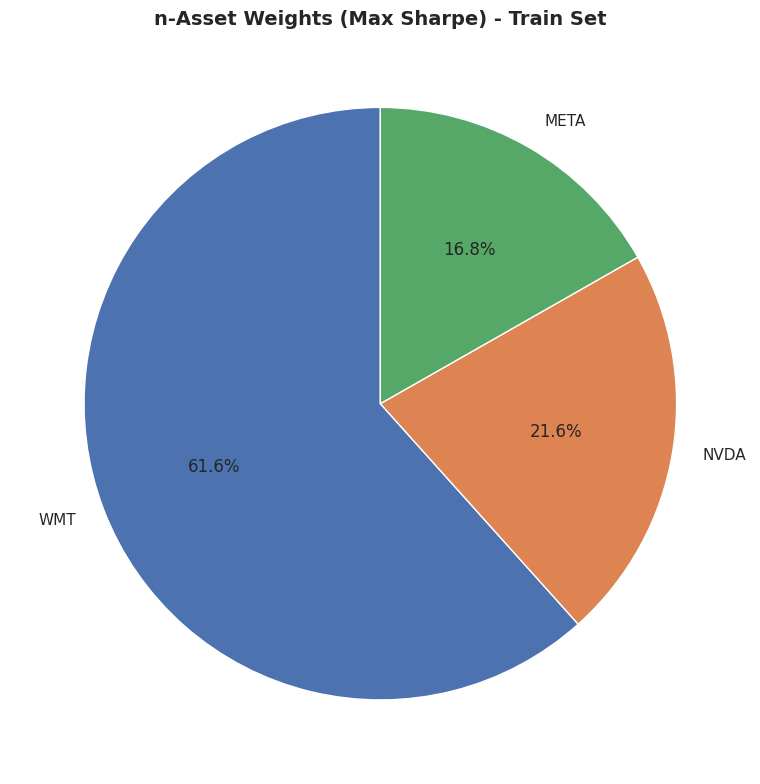


N-ASSET OPTIMIZATION: Min Volatility (Train Set)

✓ Optimization successful

Optimal Weights:
  WMT: 51.29%
  MSFT: 37.25%
  GOOGL: 11.46%

Expected Performance:
  Annual Return: 32.14%
  Annual Volatility: 17.07%
  Sharpe Ratio: 1.766


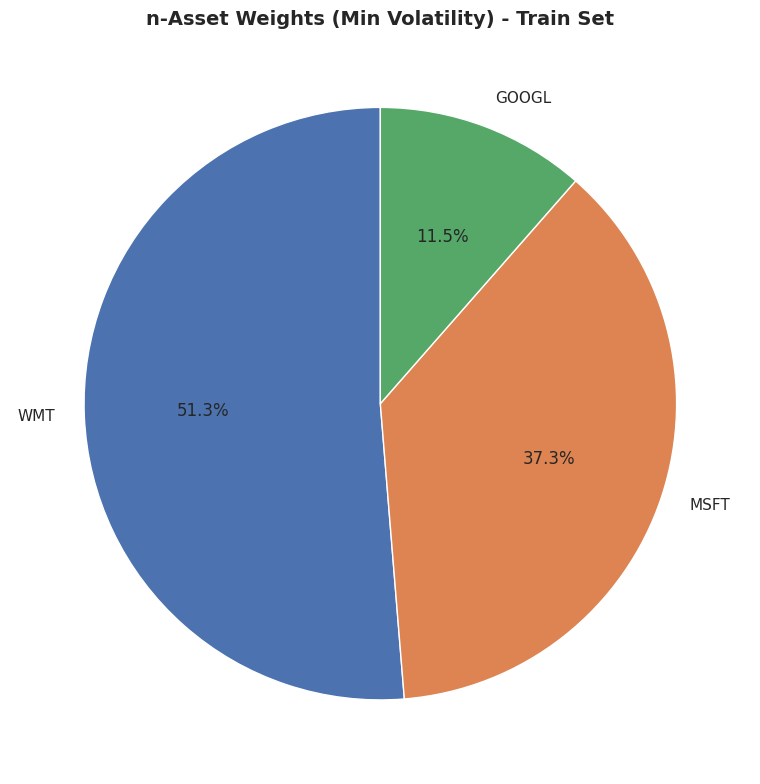

In [ ]:
# Step 3: Optimize n-asset portfolios
weights_n_sharpe, perf_n_sharpe = optimize_n_assets(
    portfolio_inputs['mu'], portfolio_inputs['S'],
    'max_sharpe', RISK_FREE_RATE, WEIGHT_BOUNDS
)
weights_n_vol, perf_n_vol = optimize_n_assets(
    portfolio_inputs['mu'], portfolio_inputs['S'],
    'min_volatility', RISK_FREE_RATE, WEIGHT_BOUNDS
)


K-OF-N SEARCH: Max Sharpe (Train Set)
Searching all combinations for k = 1 to k = 3 (n = 5)

k=1: Testing 5 combinations...

k=2: Testing 10 combinations...

k=3: Testing 10 combinations...

✓ SEARCH COMPLETE

Best Sharpe: 2.3000 (k=3 assets)

Optimal Weights:
  WMT: 61.64%
  NVDA: 21.59%
  META: 16.77%

--- Top 10 Combinations ---
 k       Combination   Sharpe  Volatility
 3   META, WMT, NVDA 2.299959    0.218191
 3  GOOGL, WMT, NVDA 2.237234    0.218254
 2         WMT, NVDA 2.233731    0.223849
 3   WMT, NVDA, MSFT 2.233731    0.223849
 3  META, GOOGL, WMT 2.080281    0.202990
 3   META, WMT, MSFT 2.070146    0.210710
 2         META, WMT 2.070146    0.210710
 3 META, GOOGL, NVDA 1.870513    0.367397
 2        META, NVDA 1.870241    0.372476
 3  META, NVDA, MSFT 1.870241    0.372476


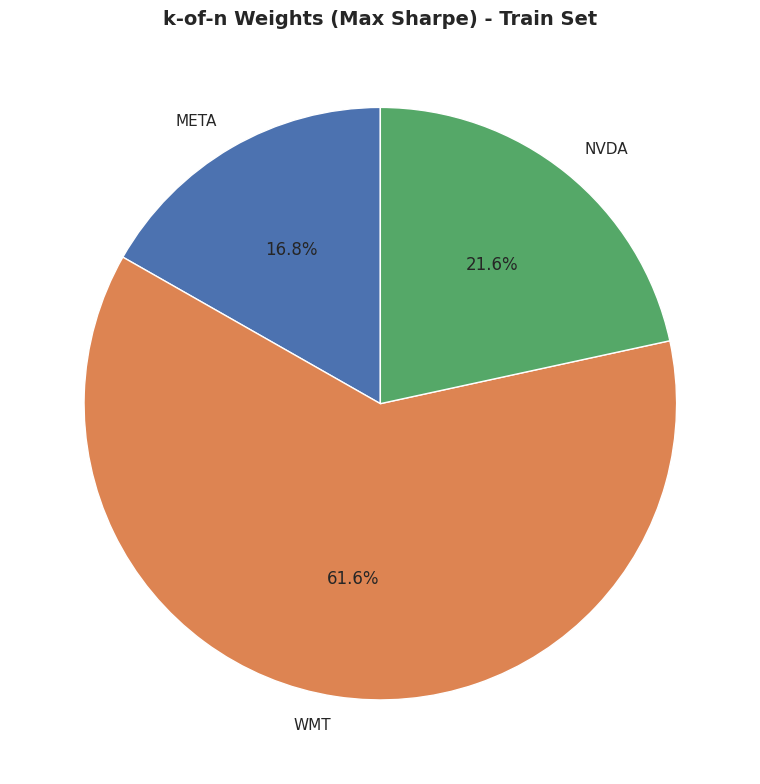


K-OF-N SEARCH: Min Volatility (Train Set)
Searching all combinations for k = 1 to k = 3 (n = 5)

k=1: Testing 5 combinations...

k=2: Testing 10 combinations...

k=3: Testing 10 combinations...

✓ SEARCH COMPLETE

Best Volatility: 0.1707 (k=3 assets)

Optimal Weights:
  WMT: 51.29%
  MSFT: 37.25%
  GOOGL: 11.46%

--- Top 10 Combinations ---
 k      Combination   Sharpe  Volatility
 3 GOOGL, WMT, MSFT 1.766056    0.170672
 2        WMT, MSFT 1.703726    0.173270
 3  META, WMT, MSFT 1.703726    0.173270
 3  WMT, NVDA, MSFT 1.703726    0.173270
 3 META, GOOGL, WMT 1.912880    0.186655
 3 GOOGL, WMT, NVDA 1.916328    0.186948
 2       GOOGL, WMT 1.836711    0.187359
 3  META, WMT, NVDA 2.110416    0.200210
 2        META, WMT 1.987442    0.202292
 2        WMT, NVDA 2.041385    0.204574


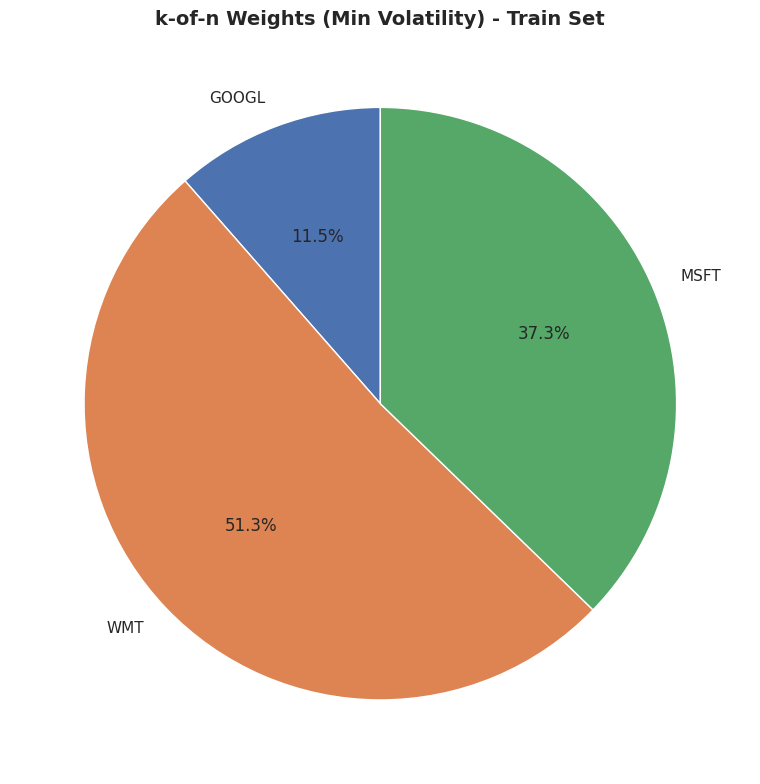

In [ ]:
# Step 4: Search k-of-n portfolios
# --- Max Sharpe (k = 3) ---
weights_k_sharpe, results_k_sharpe = search_k_of_n_portfolios(
    tickers=all_tickers,
    portfolio_inputs=portfolio_inputs,
    objective='max_sharpe',
    risk_free_rate=RISK_FREE_RATE,
    weight_bounds=WEIGHT_BOUNDS,
    k_max=3
)

# --- Min Volatility (k = 3) ---
weights_k_vol, results_k_vol = search_k_of_n_portfolios(
    tickers=all_tickers,
    portfolio_inputs=portfolio_inputs,
    objective='min_volatility',
    risk_free_rate=RISK_FREE_RATE,
    weight_bounds=WEIGHT_BOUNDS,
    k_max=3
)



PLOTTING EFFICIENT FRONTIER


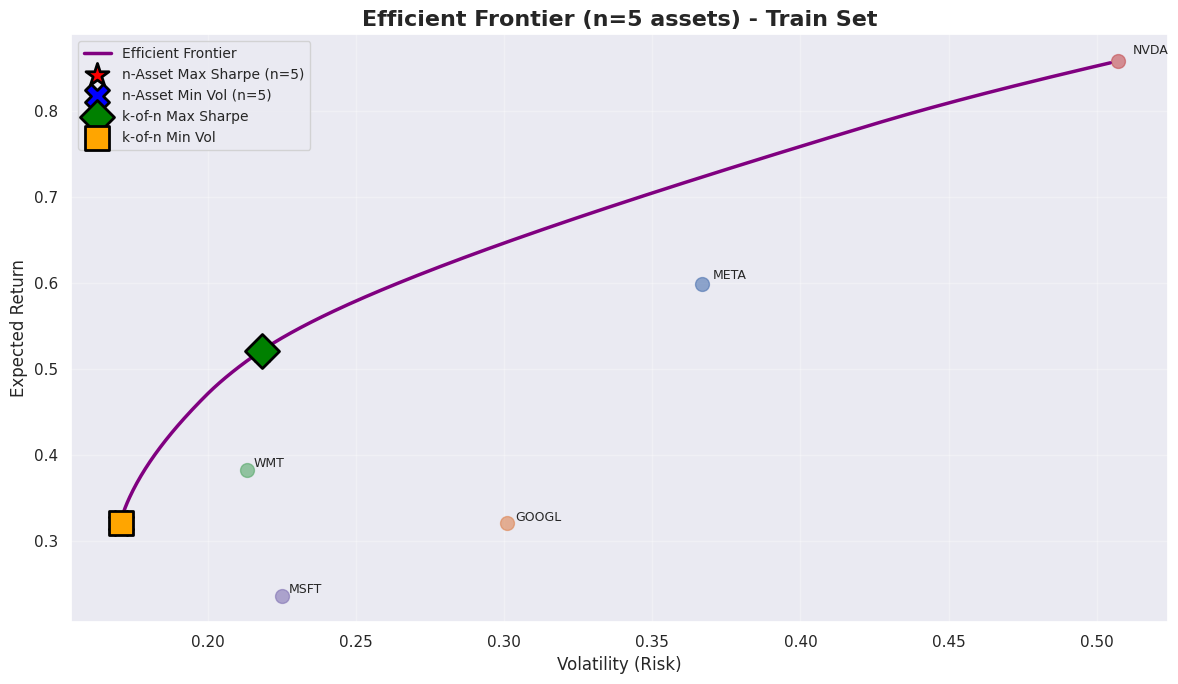

In [ ]:
# Step 5: Plot efficient frontier
portfolios_for_plot = {
    f'n-Asset Max Sharpe (n={n})': perf_n_sharpe,
    f'n-Asset Min Vol (n={n})': perf_n_vol,
    'k-of-n Max Sharpe': (
        results_k_sharpe.iloc[0]['Return'],
        results_k_sharpe.iloc[0]['Volatility'],
        results_k_sharpe.iloc[0]['Sharpe']
    ),
    'k-of-n Min Vol': (
        results_k_vol.iloc[0]['Return'],
        results_k_vol.iloc[0]['Volatility'],
        results_k_vol.iloc[0]['Sharpe']
    )
}
plot_efficient_frontier_manual(
    portfolio_inputs['mu'],
    portfolio_inputs['S'],
    portfolios_for_plot,
    n,
    RISK_FREE_RATE
)


BACKTESTING (Out-of-Sample Test Set)
Test period: 2025-09-08 to 2025-11-26
Test days: 58

--- PERFORMANCE METRICS (Out-of-Sample) ---
                          Total Return  Annual Return  Annual Volatility  Sharpe Ratio  Max Drawdown  Calmar Ratio
Min Volatility (k-of-n)          6.24%         31.33%             14.33%       218.58%        -4.11%       762.90%
Benchmark (Equal Weight)         4.71%         22.99%             16.53%       139.09%        -8.01%       287.06%
Max Sharpe (k-of-n)              2.69%         12.70%             15.70%        80.91%        -6.96%       182.55%


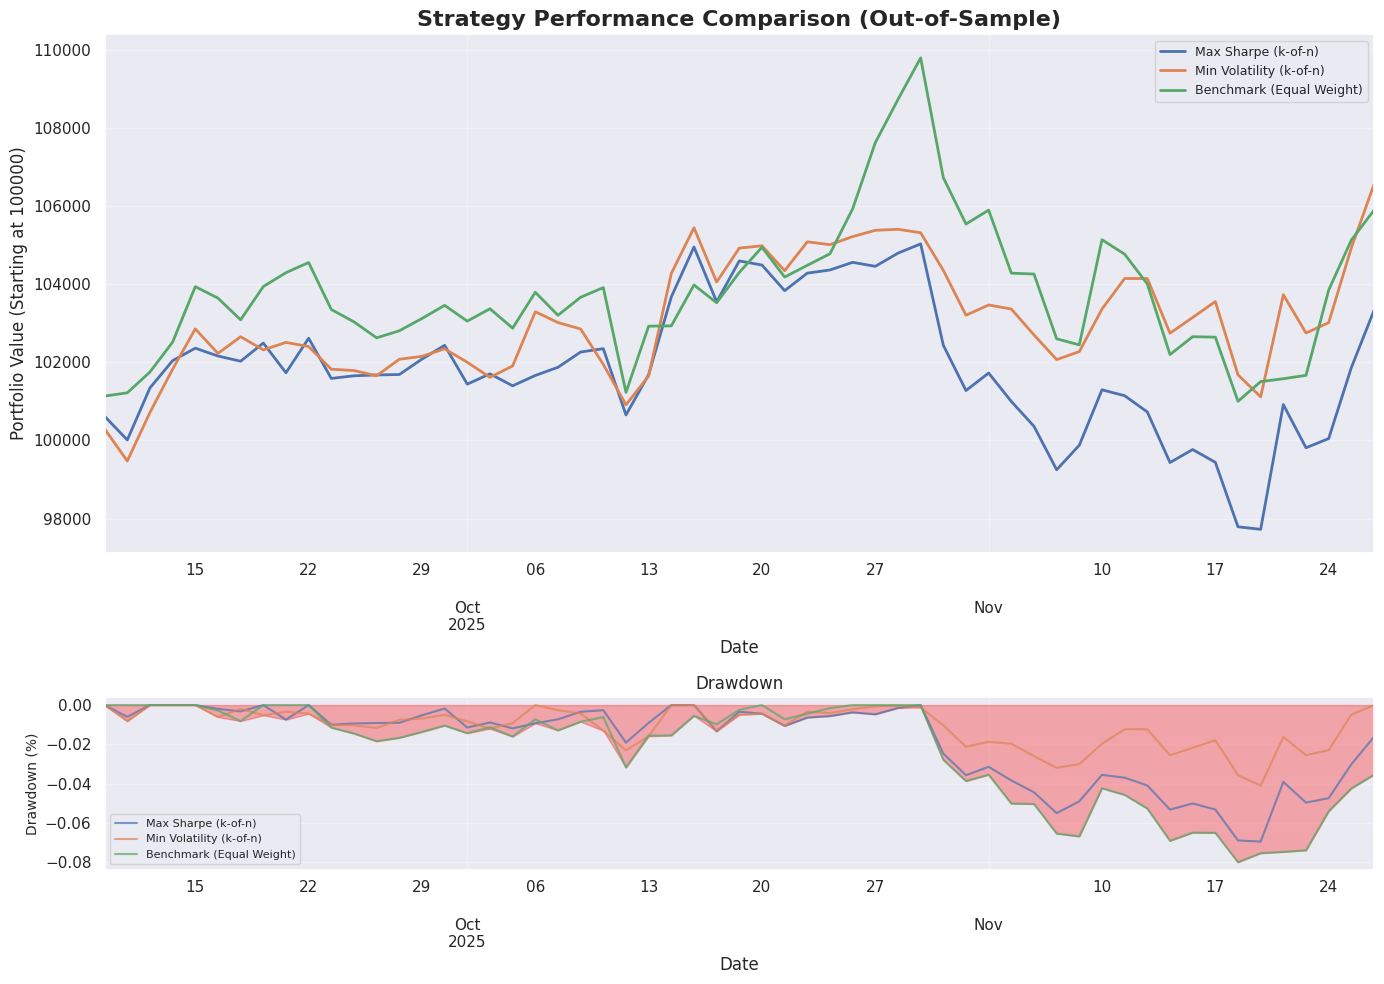


✓ PERFORMANCE RESULTS (Max Sharpe, Min Vol, Benchmark)
                          Total Return  Annual Return  Annual Volatility  Sharpe Ratio  Max Drawdown  Calmar Ratio
Min Volatility (k-of-n)          6.24%         31.33%             14.33%       218.58%        -4.11%       762.90%
Benchmark (Equal Weight)         4.71%         22.99%             16.53%       139.09%        -8.01%       287.06%
Max Sharpe (k-of-n)              2.69%         12.70%             15.70%        80.91%        -6.96%       182.55%


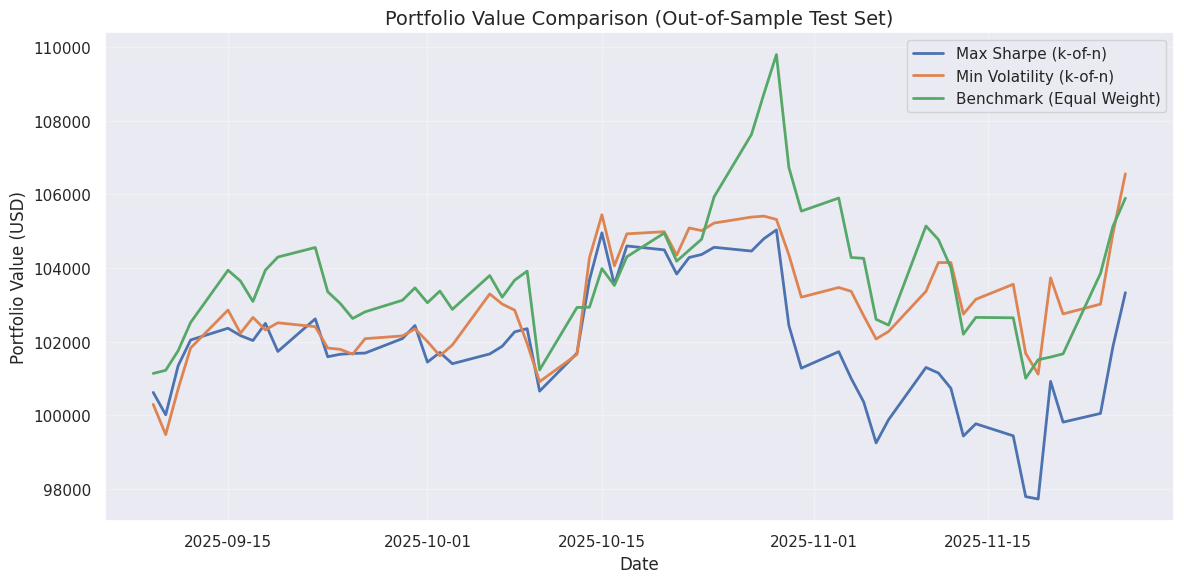

In [ ]:
# =============================================================================
# STEP 6: BACKTEST FINAL STRATEGIES (ONLY 3 STRATEGIES, CAPITAL = 100,000)
# =============================================================================

initial_capital = 100000  # <--- FIXED capital


# --- Select only required strategies ---
strategies_weights_final = {
    'Max Sharpe (k-of-n)': weights_k_sharpe,
    'Min Volatility (k-of-n)': weights_k_vol,
    'Benchmark (Equal Weight)': {ticker: 1/len(all_tickers) for ticker in all_tickers}
}


# --- Backtest ---
cumulative_final, metrics_final = backtest_all_strategies(
    test_data=test_data,
    strategies_weights=strategies_weights_final,
    tickers=all_tickers,
    risk_free_rate=RISK_FREE_RATE,
    initial_capital=initial_capital
)


# --- Print metrics ---
print("\n" + "="*80)
print("✓ PERFORMANCE RESULTS (Max Sharpe, Min Vol, Benchmark)")
print("="*80)
print(metrics_final.to_string(float_format=lambda x: f"{x:.2%}"))


# =============================================================================
# SINGLE LINE CHART — Compare all portfolio values
# =============================================================================

plt.figure(figsize=(12, 6))
for strategy in cumulative_final.columns:
    plt.plot(cumulative_final[strategy], label=strategy, linewidth=2)

plt.title("Portfolio Value Comparison (Out-of-Sample Test Set)", fontsize=14)
plt.ylabel("Portfolio Value (USD)")
plt.xlabel("Date")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


# =============================================================================
# SAVE VARIABLES FOR LATER USE
# =============================================================================
final_strategies = strategies_weights_final
final_cumulative = cumulative_final
final_metrics = metrics_final


#### 2.2.2. Performance Commentary

In [ ]:
# =============================================================================
# PERFORMANCE COMMENTARY - BEST STRATEGY ONLY
# =============================================================================

def analyze_best_strategy(metrics_df):
    """
    Identifies and explains the best strategy based on risk-adjusted returns

    Simple, clean output focusing only on the winner
    """

    print("\n" + "="*80)
    print("🏆 BEST STRATEGY ANALYSIS")
    print("="*80)

    # Find best strategy by Sharpe Ratio (risk-adjusted return)
    best_strategy = metrics_df['Sharpe Ratio'].idxmax()
    best_metrics = metrics_df.loc[best_strategy]

    annual_return = best_metrics['Annual Return']
    annual_vol = best_metrics['Annual Volatility']
    sharpe = best_metrics['Sharpe Ratio']
    max_dd = best_metrics['Max Drawdown']

    print(f"\n🥇 WINNER: {best_strategy}")
    print(f"\n📊 Performance Metrics:")
    print(f"   Annual Return:     {annual_return:>8.2%}")
    print(f"   Annual Volatility: {annual_vol:>8.2%}")
    print(f"   Sharpe Ratio:      {sharpe:>8.2f}")
    print(f"   Max Drawdown:      {max_dd:>8.2%}")

    print(f"\n💡 WHY THIS STRATEGY WON:")

    # Reason 1: Risk-Adjusted Returns
    print(f"\n   1. BEST RISK-ADJUSTED RETURNS (Sharpe Ratio: {sharpe:.2f})")
    if sharpe > 2.0:
        print(f"      → Exceptional! Earns {sharpe:.2f}% excess return per 1% of risk")
    elif sharpe > 1.0:
        print(f"      → Very good! Efficiently balances risk and reward")
    else:
        print(f"      → Acceptable risk-adjusted performance")

    # Reason 2: Returns
    print(f"\n   2. STRONG RETURNS ({annual_return:.2%} annualized)")
    if annual_return > 0.30:
        print(f"      → Outstanding returns, significantly beating the market")
    elif annual_return > 0.15:
        print(f"      → Good returns, consistently profitable")
    else:
        print(f"      → Positive returns achieved")

    # Reason 3: Risk Management
    print(f"\n   3. CONTROLLED RISK (Volatility: {annual_vol:.2%})")
    if annual_vol < 0.15:
        print(f"      → Low volatility, very stable performance")
    elif annual_vol < 0.25:
        print(f"      → Moderate volatility, reasonable risk level")
    else:
        print(f"      → Higher volatility, but compensated by strong returns")

    # Reason 4: Drawdown Protection
    print(f"\n   4. DRAWDOWN MANAGEMENT (Max Loss: {max_dd:.2%})")
    if max_dd > -0.10:
        print(f"      → Excellent downside protection")
    elif max_dd > -0.20:
        print(f"      → Acceptable drawdown control")
    else:
        print(f"      → Larger drawdowns, but overall performance justifies it")

    # Compare to benchmark
    if 'Benchmark (Equal Weight)' in metrics_df.index:
        bench_return = metrics_df.loc['Benchmark (Equal Weight)', 'Annual Return']
        bench_sharpe = metrics_df.loc['Benchmark (Equal Weight)', 'Sharpe Ratio']

        print(f"\n📈 VS BENCHMARK:")
        print(f"   Return advantage:  {annual_return - bench_return:+.2%}")
        print(f"   Sharpe advantage:  {sharpe - bench_sharpe:+.2f}")

        if annual_return > bench_return and sharpe > bench_sharpe:
            print(f"   ✅ BEATS benchmark on both returns AND risk-adjusted performance")
        elif annual_return > bench_return:
            print(f"   ⚠️  Higher returns but similar risk profile to benchmark")
        else:
            print(f"   ⚠️  Won on risk-adjusted basis despite lower absolute returns")

    print(f"\n" + "="*80)
    print(f"✓ RECOMMENDATION: Use {best_strategy} for optimal risk-adjusted returns")
    print("="*80)

    return best_strategy


In [ ]:
best = analyze_best_strategy(metrics)


🏆 BEST STRATEGY ANALYSIS

🥇 WINNER: n-Asset Min Vol

📊 Performance Metrics:
   Annual Return:       31.33%
   Annual Volatility:   14.33%
   Sharpe Ratio:          2.19
   Max Drawdown:        -4.11%

💡 WHY THIS STRATEGY WON:

   1. BEST RISK-ADJUSTED RETURNS (Sharpe Ratio: 2.19)
      → Exceptional! Earns 2.19% excess return per 1% of risk

   2. STRONG RETURNS (31.33% annualized)
      → Outstanding returns, significantly beating the market

   3. CONTROLLED RISK (Volatility: 14.33%)
      → Low volatility, very stable performance

   4. DRAWDOWN MANAGEMENT (Max Loss: -4.11%)
      → Excellent downside protection

📈 VS BENCHMARK:
   Return advantage:  +8.34%
   Sharpe advantage:  +0.79
   ✅ BEATS benchmark on both returns AND risk-adjusted performance

✓ RECOMMENDATION: Use n-Asset Min Vol for optimal risk-adjusted returns


## 3. Trading strategies

### 3.1. Code

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Dict, Tuple

# ------------------------
# DEFAULT CONFIG
# ------------------------
STRAT_DEFAULTS = {
    "fast_window": 50,
    "slow_window": 200,
    "transaction_cost": 0.001,   # fraction per trade (0.1%)
    "initial_capital": 100000.0,
    "allow_fractional_shares": True
}


#### 3.1.1. Moving average crossover

Implementing a Moving Average Crossover strategy, a trend-following approach using short-term (fast) and long-term (slow) simple moving averages (SMAs). When the fast SMA crosses above the slow SMA, it generates a buy signal (long), and when it crosses below, a sell signal (cash). The function outputs a DataFrame with prices, SMAs, a binary signal, and a Position column that flags actual trade events (+1 buy, -1 sell). This allows systematic backtesting, portfolio simulation, and comparison against benchmarks, providing a repeatable method to analyze and evaluate trend-based trading strategies.

In [ ]:
# =============================================================================
# SIGNAL GENERATOR
# =============================================================================

def ma_crossover_signals(prices: pd.Series, fast: int = None, slow: int = None) -> pd.DataFrame:
    """
    Generate signals from short/long SMA crossover.
    Returns DataFrame with: Price, SMA_fast, SMA_slow, Signal, Position
    """
    fast = fast or STRAT_DEFAULTS["fast_window"]
    slow = slow or STRAT_DEFAULTS["slow_window"]

    df = pd.DataFrame(index=prices.index)
    df["Price"] = prices.values
    df["SMA_fast"] = prices.rolling(window=fast, min_periods=1).mean().values
    df["SMA_slow"] = prices.rolling(window=slow, min_periods=1).mean().values
    df["Signal"] = (df["SMA_fast"] > df["SMA_slow"]).astype(int)
    df["Position"] = df["Signal"].diff().fillna(0).astype(int)

    return df

#### 3.1.2. Backtesting

Implementing backtesting for different trading approaches.

- The backtest_ma function simulates trading using Moving Average Crossover signals. It assumes a single asset and an event-driven, all-in/all-out style: buy fully when the short-term SMA crosses above the long-term SMA, and sell fully when it crosses below. It tracks cash, shares, portfolio value, cumulative transaction costs, and records each trade. This provides a realistic evaluation of how a trend-following strategy would have performed historically.

In [ ]:
# =============================================================================
# BACKTEST MA STRATEGY
# =============================================================================

def backtest_ma(signals_df: pd.DataFrame,
                initial_capital: float = None,
                transaction_cost: float = None,
                allow_fractional: bool = True) -> Tuple[pd.DataFrame, list, float]:
    """
    Backtest MA-crossover signals.
    Returns: augmented DataFrame, trades list, total_return
    """
    initial_capital = initial_capital if initial_capital is not None else STRAT_DEFAULTS["initial_capital"]
    transaction_cost = transaction_cost if transaction_cost is not None else STRAT_DEFAULTS["transaction_cost"]

    df = signals_df.copy()
    df["Cash"] = 0.0
    df["Shares"] = 0.0
    df["Holdings"] = 0.0
    df["Portfolio"] = 0.0
    df["Cumulative_Trade_Cost"] = 0.0

    cash = float(initial_capital)
    shares = 0.0
    cum_cost = 0.0
    trades = []

    for idx, row in df.iterrows():
        price = float(row["Price"])
        pos = int(row["Position"])

        # BUY event
        if pos == 1 and shares == 0 and price > 0:
            shares_to_buy = cash / price if allow_fractional else np.floor(cash / price)
            trade_value = shares_to_buy * price
            trade_cost = trade_value * transaction_cost
            shares = shares_to_buy
            cash = cash - trade_value - trade_cost
            cum_cost += trade_cost
            trades.append({
                "Date": idx,
                "Type": "BUY",
                "Price": price,
                "Shares": shares_to_buy,
                "Cost": trade_cost,
                "Value": trade_value
            })

        # SELL event
        elif pos == -1 and shares > 0:
            trade_value = shares * price
            trade_cost = trade_value * transaction_cost
            cash = cash + trade_value - trade_cost
            cum_cost += trade_cost
            trades.append({
                "Date": idx,
                "Type": "SELL",
                "Price": price,
                "Shares": shares,
                "Cost": trade_cost,
                "Value": trade_value
            })
            shares = 0.0

        # Update trackers
        df.at[idx, "Cash"] = cash
        df.at[idx, "Shares"] = shares
        df.at[idx, "Holdings"] = shares * price
        df.at[idx, "Portfolio"] = cash + (shares * price)
        df.at[idx, "Cumulative_Trade_Cost"] = cum_cost

    final_value = float(df["Portfolio"].iloc[-1]) if len(df) > 0 else initial_capital
    total_return = (final_value - initial_capital) / initial_capital

    return df, trades, total_return

- The backtest_buy_hold function models a passive buy-and-hold strategy. It purchases the asset at the first available price, applies a one-time transaction cost, and then tracks the portfolio value over time. This serves as a benchmark to compare active strategies against simple long-term investing.

In [ ]:
# =============================================================================
# BACKTEST BUY & HOLD
# =============================================================================

def backtest_buy_hold(prices: pd.Series,
                      initial_capital: float = None,
                      transaction_cost: float = None) -> Tuple[pd.Series, float]:
    """
    One-time buy at first price, hold until end.
    Returns: portfolio values series, total_return
    """
    initial_capital = initial_capital if initial_capital is not None else STRAT_DEFAULTS["initial_capital"]
    transaction_cost = transaction_cost if transaction_cost is not None else STRAT_DEFAULTS["transaction_cost"]

    prices = prices.dropna()
    if prices.empty:
        return pd.Series(dtype=float), 0.0

    first_price = float(prices.iloc[0])
    shares = initial_capital / first_price
    buy_cost = initial_capital * transaction_cost
    portfolio_vals = shares * prices - buy_cost
    final_value = float(portfolio_vals.iloc[-1])
    total_return = (final_value - initial_capital) / initial_capital

    return portfolio_vals, total_return

- The backtest_random_strategy function implements a random baseline. Each day, it randomly chooses to be long or in cash, with equal probability. Changes in position trigger simulated trades just like the MA strategy. This baseline helps assess whether the MA strategy adds predictive value compared to pure randomness

In [ ]:
# =============================================================================
# BACKTEST RANDOM STRATEGY
# =============================================================================

def backtest_random_strategy(prices: pd.Series,
                             seed: int = None,
                             initial_capital: float = None,
                             transaction_cost: float = None):
    """
    Random baseline: randomly choose long (1) or cash (0) each day.
    Returns: same as backtest_ma
    """
    rng = np.random.default_rng(seed)
    signals = pd.Series(rng.integers(0, 2, size=len(prices)), index=prices.index)
    df = pd.DataFrame({"Price": prices, "Signal": signals})
    df["Position"] = df["Signal"].diff().fillna(0).astype(int)
    return backtest_ma(df, initial_capital=initial_capital,
                      transaction_cost=transaction_cost, allow_fractional=True)

#### 3.1.3. Building metrics

Calculating key performance metrics for a trading strategy or portfolio. It uses the historical portfolio values to measure profitability and risk.

- Total Return shows the overall gain or loss relative to initial capital.

- Annual Return (CAGR approximation) normalizes performance to a yearly basis.

- Annual Volatility measures the variability of daily returns, indicating risk.

- Sharpe Ratio combines return and risk to assess risk-adjusted performance.

- Max Drawdown captures the largest peak-to-trough decline, showing potential loss in a downturn.

In [ ]:
# =============================================================================
# PERFORMANCE METRICS
# =============================================================================

def performance_metrics(portfolio_series: pd.Series,
                       initial_capital: float = None) -> Dict[str, float]:
    """
    Calculate comprehensive performance metrics.
    """
    initial_capital = initial_capital if initial_capital is not None else STRAT_DEFAULTS["initial_capital"]

    if portfolio_series is None or len(portfolio_series) == 0:
        return {
            "Total Return": 0.0,
            "Annual Return": 0.0,
            "Annual Vol": 0.0,
            "Sharpe": 0.0,
            "Max Drawdown": 0.0
        }

    returns = portfolio_series.pct_change().dropna()
    if returns.empty:
        return {
            "Total Return": 0.0,
            "Annual Return": 0.0,
            "Annual Vol": 0.0,
            "Sharpe": 0.0,
            "Max Drawdown": 0.0
        }

    # FIX: Calculate total return from portfolio values, not mean returns
    total_return = (portfolio_series.iloc[-1] - initial_capital) / initial_capital
    n_days = len(returns)
    annual_return = ((1 + total_return) ** (252.0 / n_days)) - 1
    annual_vol = returns.std() * np.sqrt(252.0)
    sharpe = annual_return / annual_vol if annual_vol > 0 else 0.0

    # Max drawdown
    cummax = portfolio_series.cummax()
    drawdown = (portfolio_series - cummax) / cummax
    max_dd = float(drawdown.min())

    return {
        "Total Return": total_return,
        "Annual Return": annual_return,
        "Annual Vol": annual_vol,
        "Sharpe": sharpe,
        "Max Drawdown": max_dd
    }

#### 3.1.4. Visualization

This function visualizes both price dynamics with moving averages and trading signals as well as portfolio performance.

The top plot shows the asset price with short- and long-term SMAs and marks buy (up) and sell (down) signals, making it easy to see where the strategy enters and exits trades.

The bottom plot compares the MA strategy portfolio value against a buy-and-hold benchmark, helping to visualize cumulative returns.

It also indirectly highlights drawdowns, showing how the portfolio value fluctuates from peaks over time.

In [ ]:
# =============================================================================
# PLOTTING
# =============================================================================

def plot_signals_and_portfolio(signals_df: pd.DataFrame,
                               buy_hold_series: pd.Series,
                               title_ticker: str):
    """
    Plot price + SMAs + signals, and portfolio comparison.
    """
    fig, ax = plt.subplots(2, 1, figsize=(14, 10),
                          gridspec_kw={"height_ratios": [3, 1]})
    ax0, ax1 = ax

    # Price + SMAs + signals
    ax0.plot(signals_df.index, signals_df["Price"], color="black",
            label="Price", linewidth=1.5)
    ax0.plot(signals_df.index, signals_df["SMA_fast"], color="tab:blue",
            label=f"SMA {STRAT_DEFAULTS['fast_window']}", linewidth=1.5)
    ax0.plot(signals_df.index, signals_df["SMA_slow"], color="tab:red",
            label=f"SMA {STRAT_DEFAULTS['slow_window']}", linewidth=1.5)

    buys = signals_df[signals_df["Position"] == 1]
    sells = signals_df[signals_df["Position"] == -1]

    if not buys.empty:
        ax0.scatter(buys.index, buys["Price"], marker="^", color="green",
                   s=150, label="Buy", zorder=5, edgecolors='darkgreen', linewidths=1.5)
    if not sells.empty:
        ax0.scatter(sells.index, sells["Price"], marker="v", color="red",
                   s=150, label="Sell", zorder=5, edgecolors='darkred', linewidths=1.5)

    ax0.set_title(f"{title_ticker} — Price & SMA Crossovers",
                 fontsize=14, fontweight='bold')
    ax0.set_ylabel('Price (USD)', fontsize=11)
    ax0.legend(loc="best", fontsize=10)
    ax0.grid(alpha=0.3)

    # Portfolio comparison
    if "Portfolio" in signals_df.columns and len(signals_df["Portfolio"].dropna()) > 0:
        port = signals_df["Portfolio"]
        ax1.plot(port.index, port, label="MA Crossover", color="green", linewidth=2)

    if buy_hold_series is not None and len(buy_hold_series.dropna()) > 0:
        ax1.plot(buy_hold_series.index, buy_hold_series, label="Buy & Hold",
                color="blue", linestyle="--", linewidth=2)

    ax1.set_title("Portfolio Value Comparison", fontsize=12, fontweight='bold')
    ax1.set_ylabel('Portfolio Value ($)', fontsize=11)
    ax1.set_xlabel('Date', fontsize=11)
    ax1.legend(loc="best", fontsize=10)
    ax1.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()


#### 3.1.5. Running MA Crossover Experiments (Single and Multi-Ticker)

- Handling one asset at a time. It splits the price series into a training and test set (though signals are generated and evaluated on the test/out-of-sample set). It computes MA crossover signals, runs backtests for MA, buy-and-hold, and a random baseline, calculates performance metrics (total return, annualized return, volatility, Sharpe ratio), prints a concise summary, and produces plots of price with SMAs and portfolio values. The output is a dictionary containing all relevant results for further analysis.

In [ ]:
# =============================================================================
# RUN FOR ONE TICKER
# =============================================================================

def run_ma_experiment_for_ticker(full_prices: pd.Series,
                                 split_date: pd.Timestamp,
                                 fast: int = None,
                                 slow: int = None,
                                 transaction_cost: float = None,
                                 initial_capital: float = None,
                                 random_seed: int = 42):
    """
    Run MA experiment for single ticker.
    Returns dictionary of results.
    """
    split_date = pd.to_datetime(split_date)
    train = full_prices.loc[:split_date]
    test = full_prices.loc[split_date:].iloc[1:]

    print(f"\n{'='*80}")
    print(f"MA EXPERIMENT: {full_prices.name or 'Ticker'}")
    print(f"{'='*80}")
    print(f"Test period: {test.index.min().date()} to {test.index.max().date()} ({len(test)} days)")

    # Generate signals on test data
    signals_test = ma_crossover_signals(test, fast=fast, slow=slow)

    # Run backtests
    ma_df, ma_trades, ma_ret = backtest_ma(
        signals_test,
        initial_capital=initial_capital,
        transaction_cost=transaction_cost,
        allow_fractional=True
    )

    bh_series, bh_ret = backtest_buy_hold(
        test,
        initial_capital=initial_capital,
        transaction_cost=transaction_cost
    )

    rnd_df, rnd_trades, rnd_ret = backtest_random_strategy(
        test,
        seed=random_seed,
        initial_capital=initial_capital,
        transaction_cost=transaction_cost
    )

    # Calculate metrics
    ic = initial_capital or STRAT_DEFAULTS["initial_capital"]
    ma_metrics = performance_metrics(ma_df["Portfolio"], initial_capital=ic)
    bh_metrics = performance_metrics(bh_series, initial_capital=ic)
    rnd_metrics = performance_metrics(rnd_df["Portfolio"], initial_capital=ic) if isinstance(rnd_df, pd.DataFrame) else {"Total Return": rnd_ret}

    # Print summary
    print("\n--- PERFORMANCE SUMMARY ---")
    print(f"MA Crossover:")
    print(f"  Trades: {len(ma_trades)}")
    print(f"  Total Return: {ma_metrics['Total Return']:>8.2%}")
    print(f"  Annual Return: {ma_metrics['Annual Return']:>7.2%}")
    print(f"  Annual Vol: {ma_metrics['Annual Vol']:>10.2%}")
    print(f"  Sharpe: {ma_metrics['Sharpe']:>13.2f}")
    print(f"  Max Drawdown: {ma_metrics['Max Drawdown']:>8.2%}")

    print(f"\nBuy & Hold:")
    print(f"  Total Return: {bh_metrics['Total Return']:>8.2%}")
    print(f"  Annual Return: {bh_metrics['Annual Return']:>7.2%}")
    print(f"  Annual Vol: {bh_metrics['Annual Vol']:>10.2%}")
    print(f"  Sharpe: {bh_metrics['Sharpe']:>13.2f}")
    print(f"  Max Drawdown: {bh_metrics['Max Drawdown']:>8.2%}")

    print(f"\nRandom Baseline:")
    print(f"  Trades: {len(rnd_trades)}")
    print(f"  Total Return: {rnd_metrics.get('Total Return', 0):>8.2%}")
    print(f"  Sharpe: {rnd_metrics.get('Sharpe', 0):>13.2f}")

    # Determine winner
    if ma_metrics['Sharpe'] > bh_metrics['Sharpe']:
        print(f"\n🏆 WINNER: MA Crossover (Sharpe: {ma_metrics['Sharpe']:.2f})")
    else:
        print(f"\n🏆 WINNER: Buy & Hold (Sharpe: {bh_metrics['Sharpe']:.2f})")

    # Plot
    plot_signals_and_portfolio(ma_df, bh_series, title_ticker=full_prices.name or "Ticker")

    return {
        "test_period_days": len(test),
        "ma_signals_df": ma_df,
        "ma_trades": ma_trades,
        "ma_metrics": ma_metrics,
        "bh_series": bh_series,
        "bh_metrics": bh_metrics,
        "rnd_trades": rnd_trades,
        "rnd_metrics": rnd_metrics
    }

- The following a wrapper for multiple tickers. It loops through each column (ticker) in a DataFrame of prices, calls the single-ticker experiment, and aggregates results into a dictionary keyed by ticker. This allows consistent evaluation of the strategy across a small universe of assets efficiently.

In [ ]:
# =============================================================================
# RUN FOR MULTIPLE TICKERS
# =============================================================================

def run_ma_experiment_on_universe(prices_df: pd.DataFrame,
                                  split_date: pd.Timestamp,
                                  fast: int = None,
                                  slow: int = None,
                                  transaction_cost: float = None,
                                  initial_capital: float = None,
                                  random_seed: int = 42):
    """
    Run MA experiment for all tickers in DataFrame.
    Returns dictionary with results per ticker.
    """
    results = {}
    for ticker in prices_df.columns:
        ticker_series = prices_df[ticker].copy()
        ticker_series.name = ticker

        out = run_ma_experiment_for_ticker(
            ticker_series,
            split_date,
            fast=fast,
            slow=slow,
            transaction_cost=transaction_cost,
            initial_capital=initial_capital,
            random_seed=random_seed
        )
        results[ticker] = out

    return results

print("\n✓ Part 3: Trading Strategies Functions Loaded")
print("   Use: run_ma_experiment_for_ticker() or run_ma_experiment_on_universe()")


✓ Part 3: Trading Strategies Functions Loaded
   Use: run_ma_experiment_for_ticker() or run_ma_experiment_on_universe()


### 3.2. Execution


PART 3: TRADING STRATEGIES ANALYSIS

📊 Configuration:
   Tickers: ['META' 'GOOGL' 'WMT' 'NVDA' 'MSFT']
   SMA Windows: 50/200
   Transaction Cost: 0.10%
   Initial Capital: $100,000

RUNNING EXPERIMENTS

MA EXPERIMENT: META
Test period: 2025-01-02 to 2025-11-26 (227 days)

--- PERFORMANCE SUMMARY ---
MA Crossover:
  Trades: 3
  Total Return:  -21.38%
  Annual Return: -23.53%
  Annual Vol:     31.86%
  Sharpe:         -0.74
  Max Drawdown:  -31.97%

Buy & Hold:
  Total Return:    5.88%
  Annual Return:   6.58%
  Annual Vol:     39.36%
  Sharpe:          0.17
  Max Drawdown:  -34.18%

Random Baseline:
  Trades: 123
  Total Return:  -19.75%
  Sharpe:         -0.83

🏆 WINNER: Buy & Hold (Sharpe: 0.17)


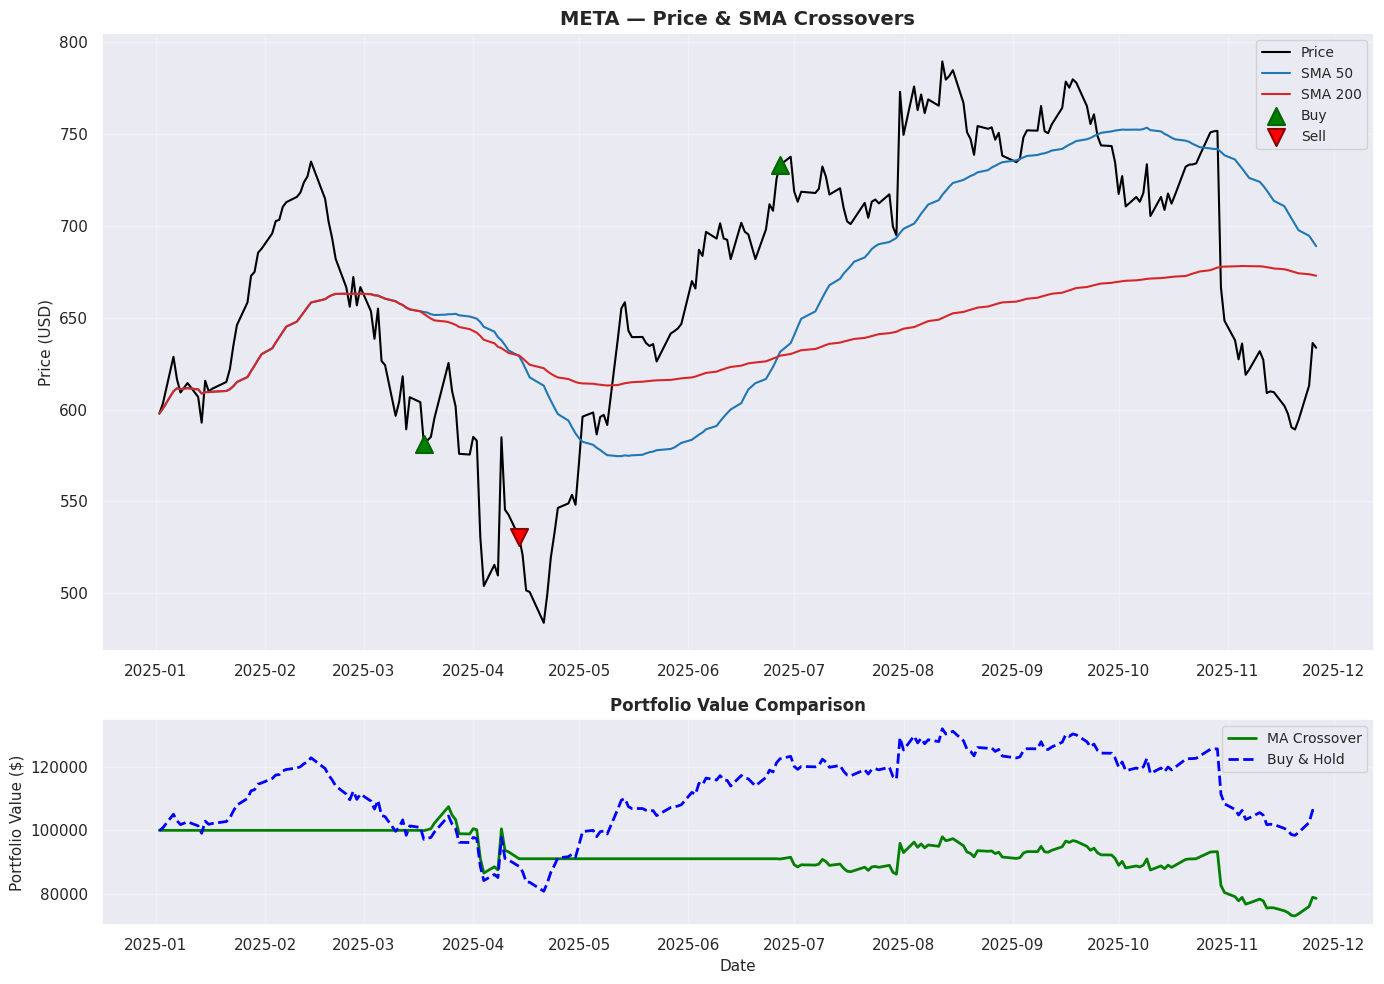


MA EXPERIMENT: GOOGL
Test period: 2025-01-02 to 2025-11-26 (227 days)

--- PERFORMANCE SUMMARY ---
MA Crossover:
  Trades: 1
  Total Return:   67.26%
  Annual Return:  77.46%
  Annual Vol:     19.80%
  Sharpe:          3.91
  Max Drawdown:   -7.13%

Buy & Hold:
  Total Return:   69.35%
  Annual Return:  79.93%
  Annual Vol:     33.36%
  Sharpe:          2.40
  Max Drawdown:  -29.83%

Random Baseline:
  Trades: 123
  Total Return:   23.91%
  Sharpe:          1.16

🏆 WINNER: MA Crossover (Sharpe: 3.91)


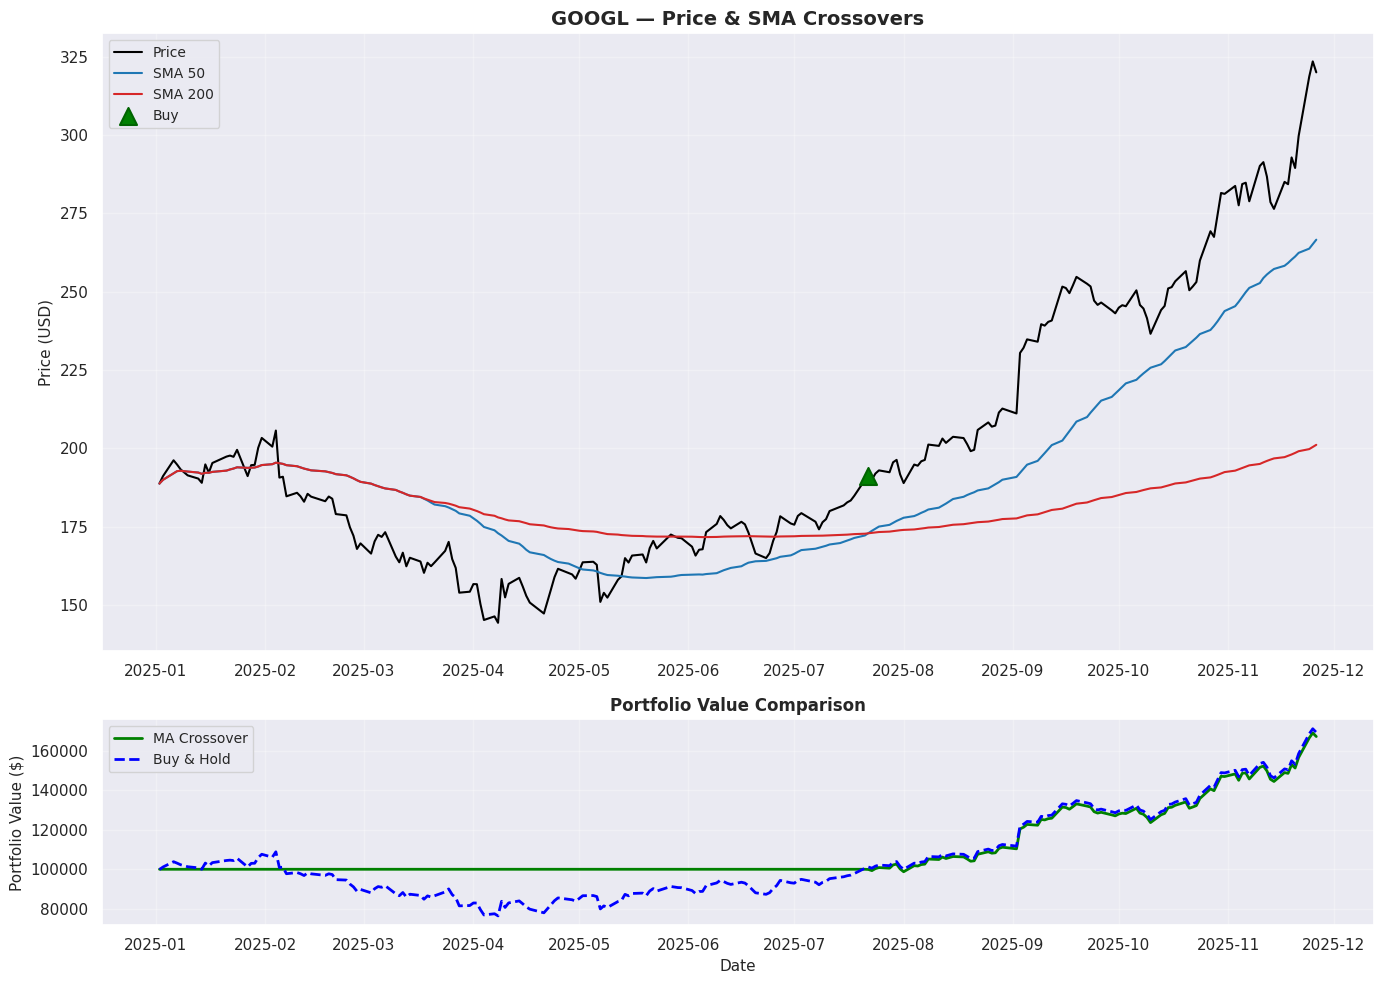


MA EXPERIMENT: WMT
Test period: 2025-01-02 to 2025-11-26 (227 days)

--- PERFORMANCE SUMMARY ---
MA Crossover:
  Trades: 3
  Total Return:   21.03%
  Annual Return:  23.71%
  Annual Vol:     20.46%
  Sharpe:          1.16
  Max Drawdown:   -8.89%

Buy & Hold:
  Total Return:   22.03%
  Annual Return:  24.86%
  Annual Vol:     25.85%
  Sharpe:          0.96
  Max Drawdown:  -21.95%

Random Baseline:
  Trades: 123
  Total Return:   -6.51%
  Sharpe:         -0.45

🏆 WINNER: MA Crossover (Sharpe: 1.16)


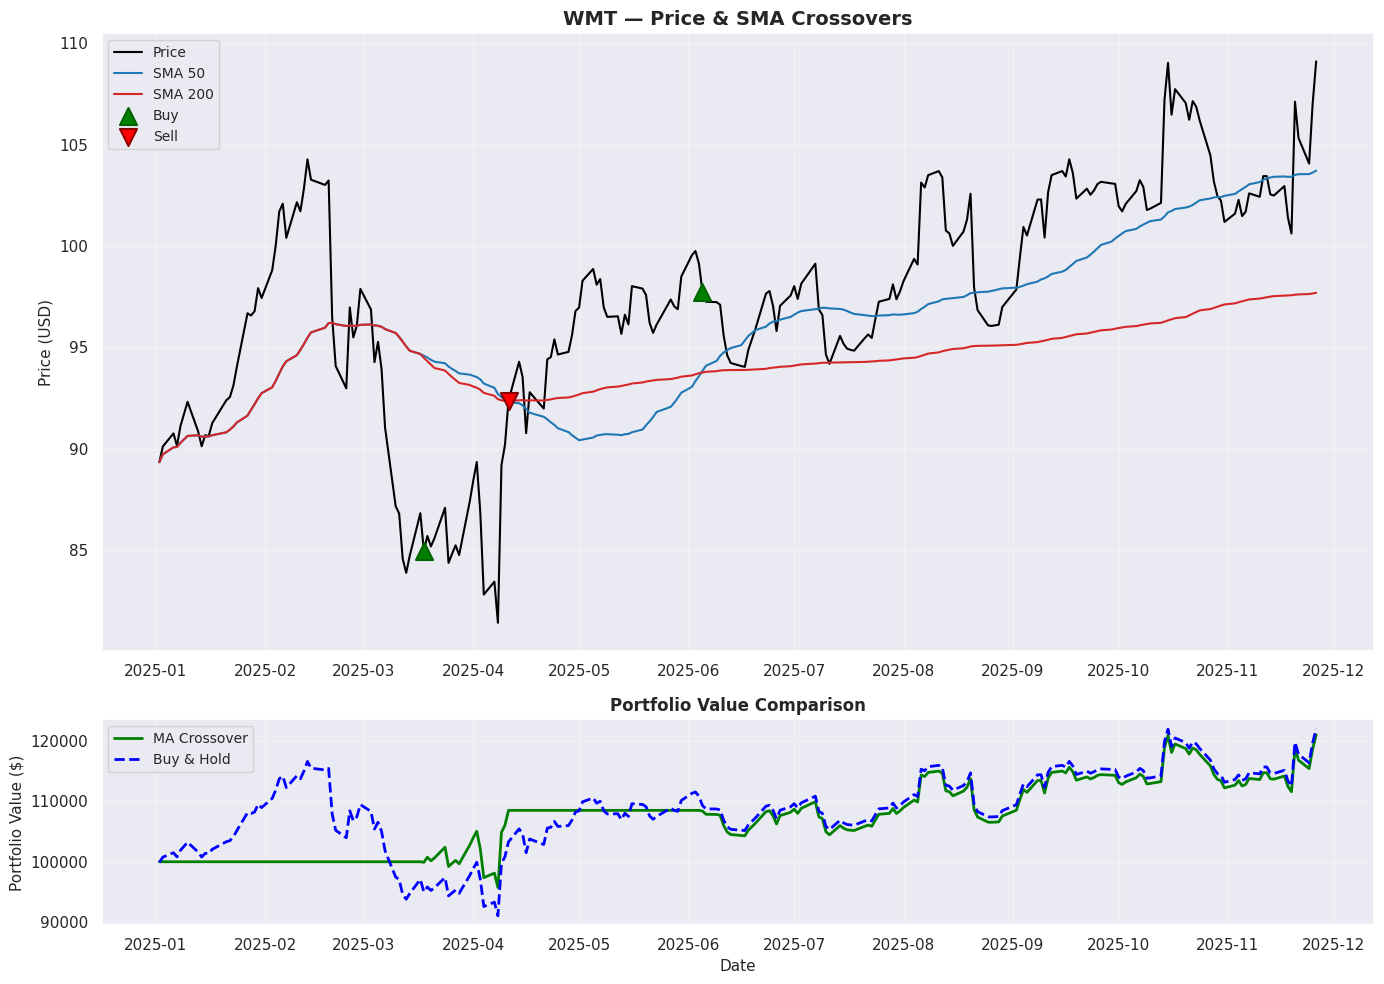


MA EXPERIMENT: NVDA
Test period: 2025-01-02 to 2025-11-26 (227 days)

--- PERFORMANCE SUMMARY ---
MA Crossover:
  Trades: 1
  Total Return:   25.22%
  Annual Return:  28.50%
  Annual Vol:     23.34%
  Sharpe:          1.22
  Max Drawdown:  -14.12%

Buy & Hold:
  Total Return:   30.26%
  Annual Return:  34.28%
  Annual Vol:     51.33%
  Sharpe:          0.67
  Max Drawdown:  -36.92%

Random Baseline:
  Trades: 123
  Total Return:  -23.40%
  Sharpe:         -0.68

🏆 WINNER: MA Crossover (Sharpe: 1.22)


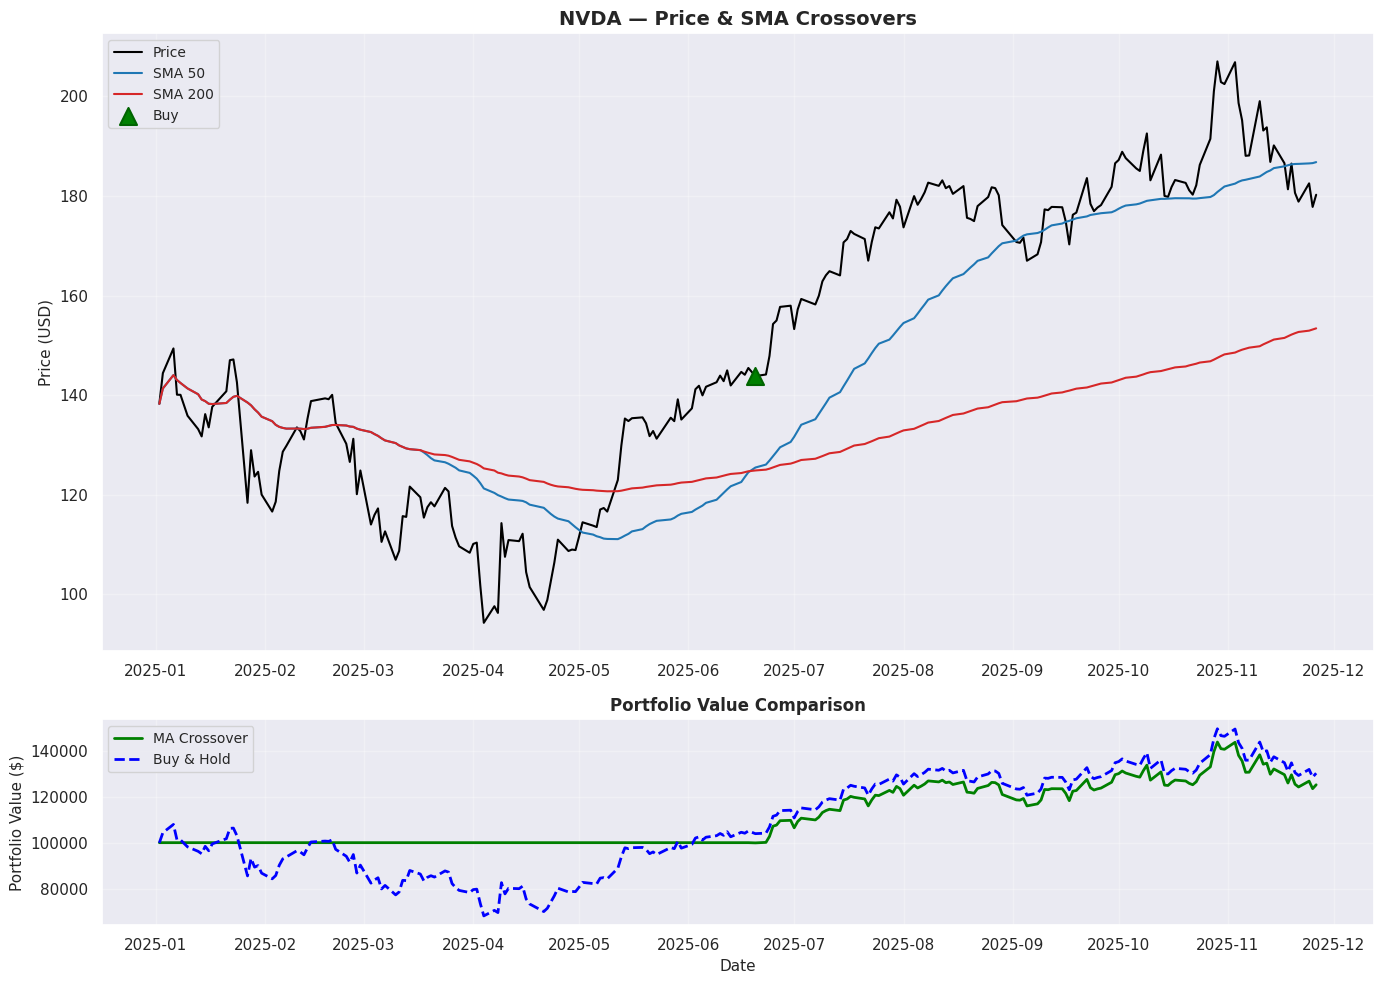


MA EXPERIMENT: MSFT
Test period: 2025-01-02 to 2025-11-26 (227 days)

--- PERFORMANCE SUMMARY ---
MA Crossover:
  Trades: 1
  Total Return:    5.36%
  Annual Return:   6.00%
  Annual Vol:     12.54%
  Sharpe:          0.48
  Max Drawdown:  -12.75%

Buy & Hold:
  Total Return:   16.74%
  Annual Return:  18.84%
  Annual Vol:     24.93%
  Sharpe:          0.76
  Max Drawdown:  -20.58%

Random Baseline:
  Trades: 123
  Total Return:   -9.57%
  Sharpe:         -0.66

🏆 WINNER: Buy & Hold (Sharpe: 0.76)


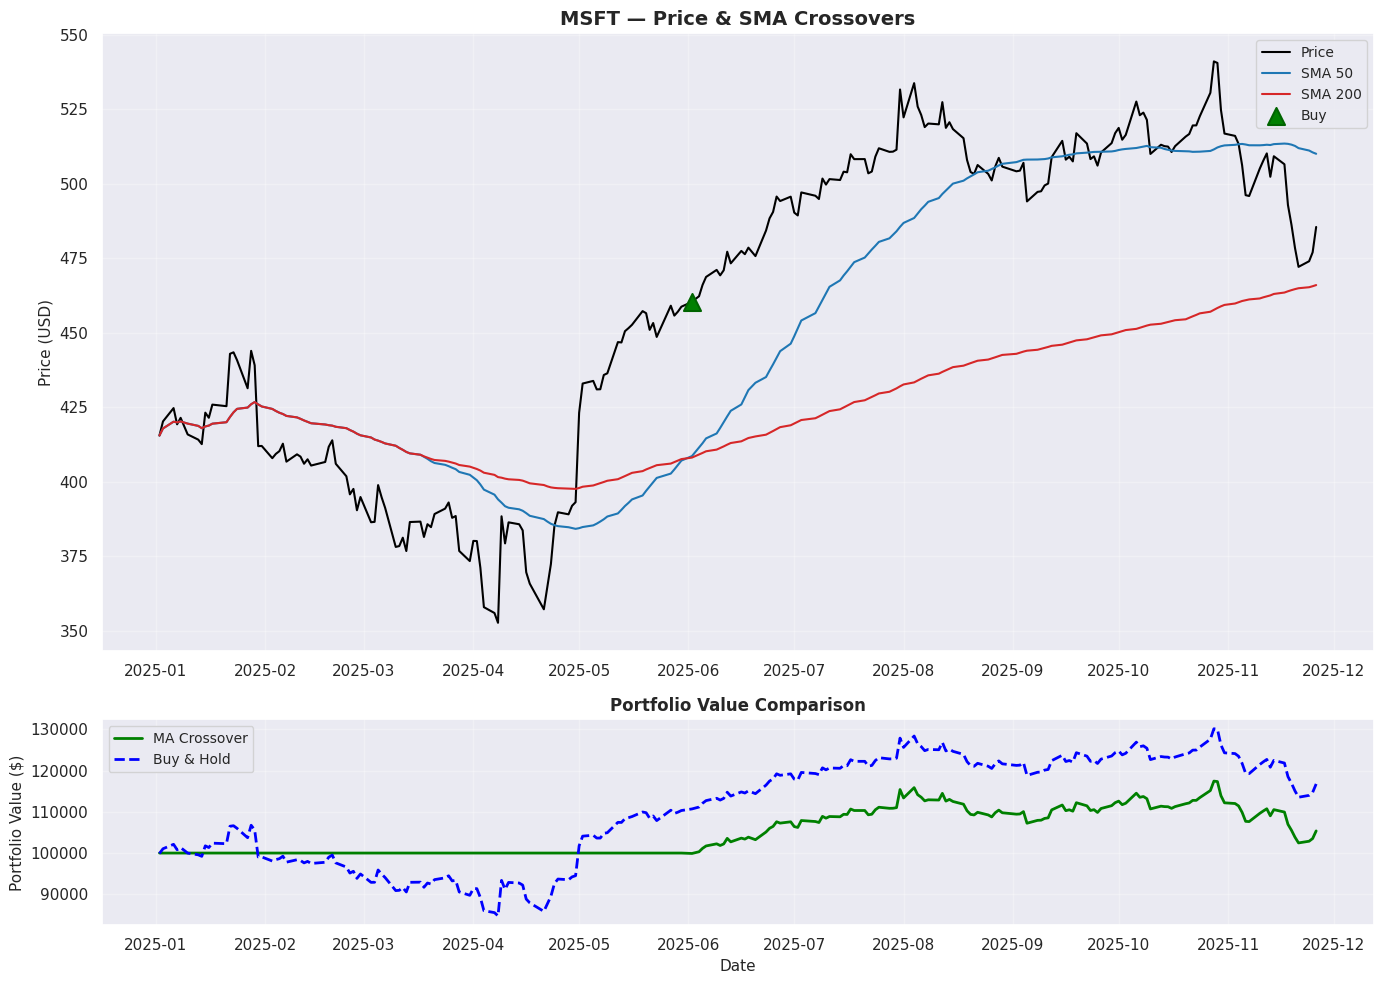


AGGREGATE PERFORMANCE SUMMARY

--- All Strategies Performance ---
Ticker     Strategy Total Return Annual Return Annual Vol  Sharpe Max Drawdown  Trades
  META MA Crossover      -21.38%       -23.53%     31.86% -73.86%      -31.97%       3
  META   Buy & Hold        5.88%         6.58%     39.36%  16.72%      -34.18%       1
 GOOGL MA Crossover       67.26%        77.46%     19.80% 391.15%       -7.13%       1
 GOOGL   Buy & Hold       69.35%        79.93%     33.36% 239.64%      -29.83%       1
   WMT MA Crossover       21.03%        23.71%     20.46% 115.91%       -8.89%       3
   WMT   Buy & Hold       22.03%        24.86%     25.85%  96.16%      -21.95%       1
  NVDA MA Crossover       25.22%        28.50%     23.34% 122.09%      -14.12%       1
  NVDA   Buy & Hold       30.26%        34.28%     51.33%  66.79%      -36.92%       1
  MSFT MA Crossover        5.36%         6.00%     12.54%  47.84%      -12.75%       1
  MSFT   Buy & Hold       16.74%        18.84%     24.93%  75.5

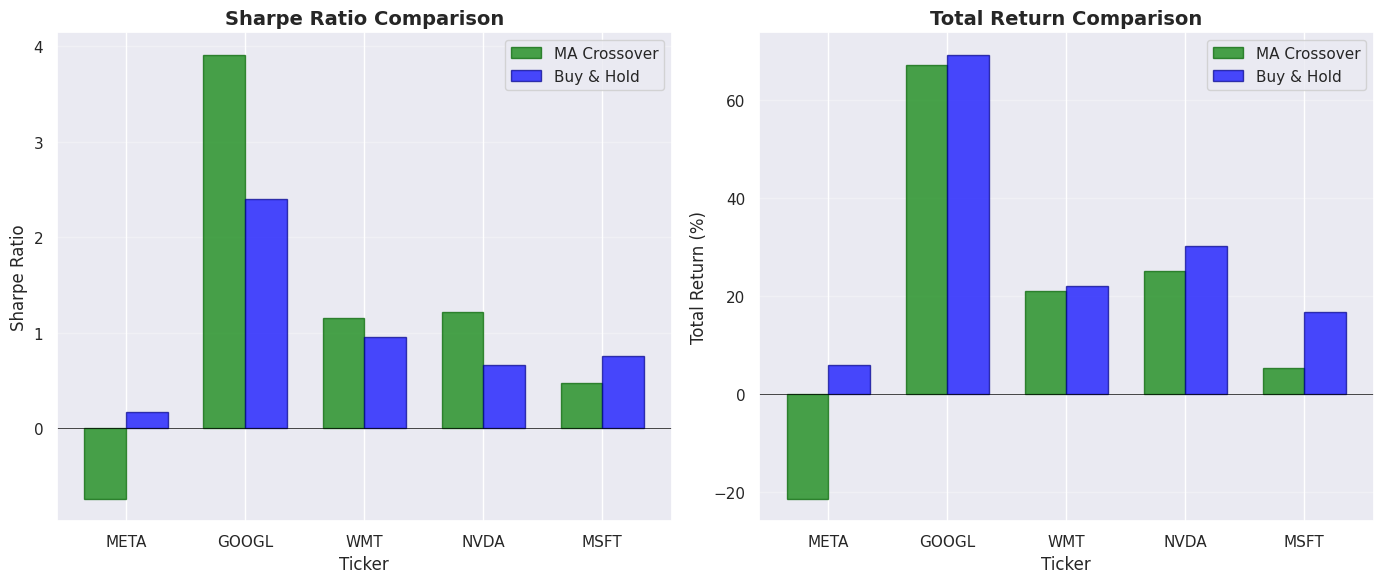


FINAL SUMMARY

--- Sharpe Ratio by Strategy & Ticker ---
Ticker        GOOGL   META  MSFT   NVDA    WMT
Strategy                                      
Buy & Hold   239.64  16.72 75.58  66.79  96.16
MA Crossover 391.15 -73.86 47.84 122.09 115.91

--- Key Statistics ---
Total MA Trades: 9
Average Trades per Ticker: 1.8
Transaction Cost per Trade: 0.10%
Total Transaction Costs: ~900 USD

🎯 RECOMMENDATION: Use MA Crossover for Active Trading
   Configuration: 50/200 SMA
   Expected Sharpe: 1.206
✓ PART 3 COMPLETE


In [ ]:
# =============================================================================
# COMPLETE PART 3 PIPELINE - TRADING STRATEGIES
# =============================================================================

print("\n" + "="*80)
print("PART 3: TRADING STRATEGIES ANALYSIS")
print("="*80)

# =============================================================================
# CONFIGURATION
# =============================================================================

TRADING_CONFIG = {
    'tickers': all_tickers,  # Use tickers from Part 1
    'split_date': '2024-12-31',  # Same as Part 2
    'fast_window': 50,
    'slow_window': 200,
    'transaction_cost': 0.001,  # 0.1%
    'initial_capital': 100000,
    'random_seed': 42
}

print(f"\n📊 Configuration:")
print(f"   Tickers: {TRADING_CONFIG['tickers']}")
print(f"   SMA Windows: {TRADING_CONFIG['fast_window']}/{TRADING_CONFIG['slow_window']}")
print(f"   Transaction Cost: {TRADING_CONFIG['transaction_cost']:.2%}")
print(f"   Initial Capital: ${TRADING_CONFIG['initial_capital']:,.0f}")

# =============================================================================
# RUN EXPERIMENTS FOR ALL TICKERS
# =============================================================================

print(f"\n{'='*80}")
print("RUNNING EXPERIMENTS")
print(f"{'='*80}")

all_results = run_ma_experiment_on_universe(
    intro_data,
    split_date=TRADING_CONFIG['split_date'],
    fast=TRADING_CONFIG['fast_window'],
    slow=TRADING_CONFIG['slow_window'],
    transaction_cost=TRADING_CONFIG['transaction_cost'],
    initial_capital=TRADING_CONFIG['initial_capital'],
    random_seed=TRADING_CONFIG['random_seed']
)

# =============================================================================
# AGGREGATE RESULTS
# =============================================================================

print(f"\n{'='*80}")
print("AGGREGATE PERFORMANCE SUMMARY")
print(f"{'='*80}")

summary_data = []
for ticker, results in all_results.items():
    ma_m = results['ma_metrics']
    bh_m = results['bh_metrics']

    summary_data.append({
        'Ticker': ticker,
        'Strategy': 'MA Crossover',
        'Total Return': ma_m['Total Return'],
        'Annual Return': ma_m['Annual Return'],
        'Annual Vol': ma_m['Annual Vol'],
        'Sharpe': ma_m['Sharpe'],
        'Max Drawdown': ma_m['Max Drawdown'],
        'Trades': len(results['ma_trades'])
    })

    summary_data.append({
        'Ticker': ticker,
        'Strategy': 'Buy & Hold',
        'Total Return': bh_m['Total Return'],
        'Annual Return': bh_m['Annual Return'],
        'Annual Vol': bh_m['Annual Vol'],
        'Sharpe': bh_m['Sharpe'],
        'Max Drawdown': bh_m['Max Drawdown'],
        'Trades': 1
    })

summary_df = pd.DataFrame(summary_data)

print("\n--- All Strategies Performance ---")
for col in ['Total Return', 'Annual Return', 'Annual Vol', 'Sharpe', 'Max Drawdown']:
    summary_df[col] = summary_df[col].apply(lambda x: f"{x:.2%}" if abs(x) < 10 else f"{x:.2f}")

print(summary_df.to_string(index=False))

# =============================================================================
# WINNER BY TICKER
# =============================================================================

print(f"\n{'='*80}")
print("WINNER BY TICKER (Based on Sharpe Ratio)")
print(f"{'='*80}")

for ticker in TRADING_CONFIG['tickers']:
    if ticker not in all_results:
        continue

    results = all_results[ticker]
    ma_sharpe = results['ma_metrics']['Sharpe']
    bh_sharpe = results['bh_metrics']['Sharpe']
    ma_return = results['ma_metrics']['Total Return']
    bh_return = results['bh_metrics']['Total Return']

    if ma_sharpe > bh_sharpe:
        winner = "MA Crossover"
        winner_sharpe = ma_sharpe
        advantage = ma_sharpe - bh_sharpe
        symbol = "📈"
    else:
        winner = "Buy & Hold"
        winner_sharpe = bh_sharpe
        advantage = bh_sharpe - ma_sharpe
        symbol = "🛡️"

    print(f"\n{symbol} {ticker}: {winner}")
    print(f"   Sharpe: {winner_sharpe:.3f} (advantage: {advantage:+.3f})")
    print(f"   MA Return: {ma_return:.2%} | BH Return: {bh_return:.2%}")

# =============================================================================
# OVERALL WINNER
# =============================================================================

print(f"\n{'='*80}")
print("OVERALL BEST STRATEGY")
print(f"{'='*80}")

# Calculate averages
ma_sharpes = [all_results[t]['ma_metrics']['Sharpe'] for t in TRADING_CONFIG['tickers']]
bh_sharpes = [all_results[t]['bh_metrics']['Sharpe'] for t in TRADING_CONFIG['tickers']]
ma_returns = [all_results[t]['ma_metrics']['Total Return'] for t in TRADING_CONFIG['tickers']]
bh_returns = [all_results[t]['bh_metrics']['Total Return'] for t in TRADING_CONFIG['tickers']]

avg_ma_sharpe = np.mean(ma_sharpes)
avg_bh_sharpe = np.mean(bh_sharpes)
avg_ma_return = np.mean(ma_returns)
avg_bh_return = np.mean(bh_returns)

print(f"\nAverage Performance ({len(TRADING_CONFIG['tickers'])} tickers):")
print(f"\n{'Strategy':<20} {'Sharpe':<10} {'Return':<10}")
print(f"{'-'*40}")
print(f"{'MA Crossover':<20} {avg_ma_sharpe:<10.3f} {avg_ma_return:<10.2%}")
print(f"{'Buy & Hold':<20} {avg_bh_sharpe:<10.3f} {avg_bh_return:<10.2%}")

# Determine winner
if avg_ma_sharpe > avg_bh_sharpe:
    print(f"\n🏆 OVERALL WINNER: MA Crossover ({TRADING_CONFIG['fast_window']}/{TRADING_CONFIG['slow_window']} SMA)")
    print(f"   Advantage: {avg_ma_sharpe - avg_bh_sharpe:+.3f} Sharpe points")
    print(f"\n💡 INSIGHT: Active trading with SMA crossover outperforms")
    print(f"   passive investing on a risk-adjusted basis.")
else:
    print(f"\n🏆 OVERALL WINNER: Buy & Hold")
    print(f"   Advantage: {avg_bh_sharpe - avg_ma_sharpe:+.3f} Sharpe points")
    print(f"\n💡 INSIGHT: Passive investing outperforms active trading")
    print(f"   after accounting for transaction costs.")

# Win rate
ma_wins = sum(1 for t in TRADING_CONFIG['tickers']
              if all_results[t]['ma_metrics']['Sharpe'] > all_results[t]['bh_metrics']['Sharpe'])
win_rate = (ma_wins / len(TRADING_CONFIG['tickers'])) * 100

print(f"\n📊 MA Crossover Win Rate: {ma_wins}/{len(TRADING_CONFIG['tickers'])} ({win_rate:.0f}%)")

# =============================================================================
# COMPARISON VISUALIZATION
# =============================================================================

print(f"\n{'='*80}")
print("CREATING COMPARISON CHARTS")
print(f"{'='*80}")

tickers_list = list(all_results.keys())
ma_sharpes_plot = [all_results[t]['ma_metrics']['Sharpe'] for t in tickers_list]
bh_sharpes_plot = [all_results[t]['bh_metrics']['Sharpe'] for t in tickers_list]
ma_returns_plot = [all_results[t]['ma_metrics']['Total Return'] * 100 for t in tickers_list]
bh_returns_plot = [all_results[t]['bh_metrics']['Total Return'] * 100 for t in tickers_list]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Sharpe Ratio comparison
x = np.arange(len(tickers_list))
width = 0.35

ax1.bar(x - width/2, ma_sharpes_plot, width, label='MA Crossover',
        color='green', alpha=0.7, edgecolor='darkgreen')
ax1.bar(x + width/2, bh_sharpes_plot, width, label='Buy & Hold',
        color='blue', alpha=0.7, edgecolor='darkblue')
ax1.set_xlabel('Ticker', fontsize=12)
ax1.set_ylabel('Sharpe Ratio', fontsize=12)
ax1.set_title('Sharpe Ratio Comparison', fontsize=14, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(tickers_list)
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3, axis='y')
ax1.axhline(y=0, color='black', linestyle='-', linewidth=0.5)

# Total Return comparison
ax2.bar(x - width/2, ma_returns_plot, width, label='MA Crossover',
        color='green', alpha=0.7, edgecolor='darkgreen')
ax2.bar(x + width/2, bh_returns_plot, width, label='Buy & Hold',
        color='blue', alpha=0.7, edgecolor='darkblue')
ax2.set_xlabel('Ticker', fontsize=12)
ax2.set_ylabel('Total Return (%)', fontsize=12)
ax2.set_title('Total Return Comparison', fontsize=14, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(tickers_list)
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3, axis='y')
ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.5)

plt.tight_layout()
plt.show()

# =============================================================================
# FINAL SUMMARY
# =============================================================================

print(f"\n{'='*80}")
print("FINAL SUMMARY")
print(f"{'='*80}")

# Pivot table
pivot_sharpe = summary_df[summary_df['Strategy'].isin(['MA Crossover', 'Buy & Hold'])].copy()
pivot_sharpe['Sharpe_num'] = pivot_sharpe['Sharpe'].str.rstrip('%').astype(float)
pivot_table = pivot_sharpe.pivot_table(
    index='Strategy',
    columns='Ticker',
    values='Sharpe_num',
    aggfunc='first'
)

print("\n--- Sharpe Ratio by Strategy & Ticker ---")
print(pivot_table.to_string(float_format=lambda x: f"{x:.2f}"))

# Key statistics
print(f"\n--- Key Statistics ---")
total_ma_trades = sum(len(all_results[t]['ma_trades']) for t in tickers_list)
avg_trades_per_ticker = total_ma_trades / len(tickers_list)

print(f"Total MA Trades: {total_ma_trades}")
print(f"Average Trades per Ticker: {avg_trades_per_ticker:.1f}")
print(f"Transaction Cost per Trade: {TRADING_CONFIG['transaction_cost']:.2%}")
print(f"Total Transaction Costs: ~{total_ma_trades * TRADING_CONFIG['transaction_cost'] * TRADING_CONFIG['initial_capital']:,.0f} USD")

# Final recommendation
print(f"\n{'='*80}")
if avg_ma_sharpe > avg_bh_sharpe:
    print("🎯 RECOMMENDATION: Use MA Crossover for Active Trading")
    print(f"   Configuration: {TRADING_CONFIG['fast_window']}/{TRADING_CONFIG['slow_window']} SMA")
    print(f"   Expected Sharpe: {avg_ma_sharpe:.3f}")
else:
    print("🎯 RECOMMENDATION: Stick with Buy & Hold")
    print(f"   Rationale: Better risk-adjusted returns with minimal trading")
    print(f"   Expected Sharpe: {avg_bh_sharpe:.3f}")

print(f"{'='*80}")
print("✓ PART 3 COMPLETE")
print(f"{'='*80}")

## 4. Results and Discoveries

### 4.1. Optimization

In [ ]:
# Print weights of top 3 stocks using Max Sharpe and Min Volatility strategies
# =============================================================================

def print_top_3_weights(name, weight_dict):
    print(f"\n=== Top 3 Assets — {name} ===")
    # Sort weights descending
    sorted_w = sorted(weight_dict.items(), key=lambda x: x[1], reverse=True)
    # Print only the top 3 with > 0 weight
    top3 = [(ticker, w) for ticker, w in sorted_w if w > 0][:3]
    for ticker, w in top3:
        print(f"{ticker}: {w:.2%}")


# ---- Print results ----
print_top_3_weights("Max Sharpe (k-of-n)", weights_k_sharpe)
print_top_3_weights("Min Volatility (k-of-n)", weights_k_vol)



=== Top 3 Assets — Max Sharpe (k-of-n) ===
WMT: 61.64%
NVDA: 21.59%
META: 16.77%

=== Top 3 Assets — Min Volatility (k-of-n) ===
WMT: 51.29%
MSFT: 37.25%
GOOGL: 11.46%


### 4.2. Backtesting

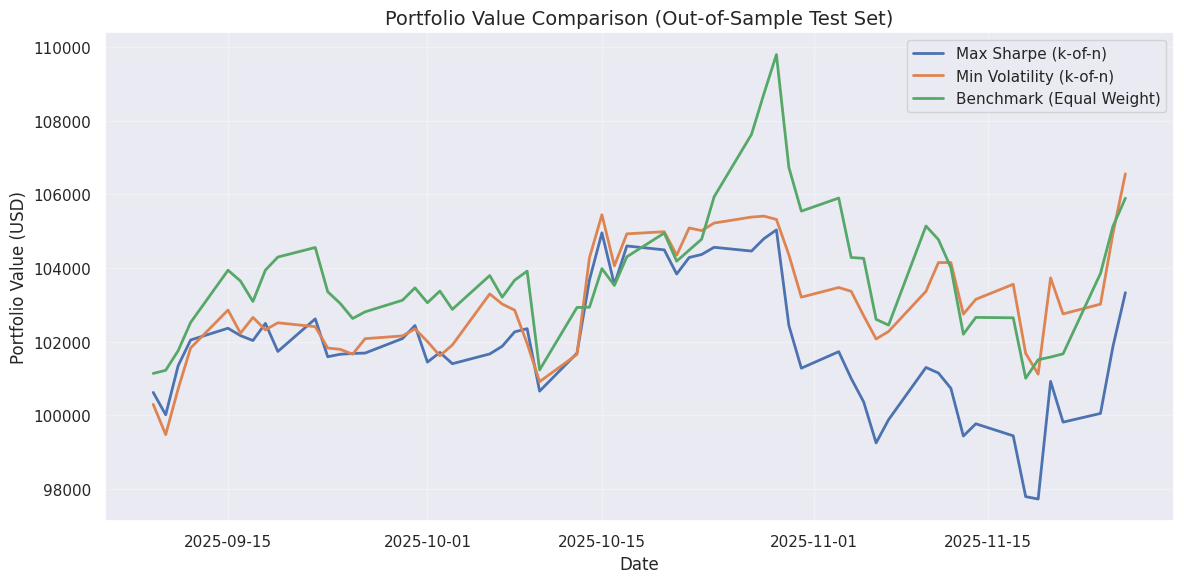

In [ ]:
# Print a single line chart comparing daily portfolio values of 3 strategies
plt.figure(figsize=(12, 6))
for strategy in cumulative_final.columns:
    plt.plot(cumulative_final[strategy], label=strategy, linewidth=2)

plt.title("Portfolio Value Comparison (Out-of-Sample Test Set)", fontsize=14)
plt.ylabel("Portfolio Value (USD)")
plt.xlabel("Date")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

### 4.3. Analysis

#### **Correlation**


Daily Log Returns (first 5 rows):
                META     GOOGL       WMT      NVDA      MSFT
Date                                                        
2023-09-05  0.012640  0.000810 -0.008079  0.000804  0.014769
2023-09-06 -0.003270 -0.009696  0.007460 -0.031026 -0.002011
2023-09-07 -0.001673  0.005932  0.012310 -0.017578 -0.008962
2023-09-08 -0.002615  0.008247  0.001833 -0.014573  0.013129
2023-09-11  0.031946  0.003951  0.003474 -0.008683  0.010919

Correlation Matrix:
           META     GOOGL       WMT      NVDA      MSFT
META   1.000000  0.448217  0.230290  0.474033  0.615172
GOOGL  0.448217  1.000000  0.131029  0.413770  0.482344
WMT    0.230290  0.131029  1.000000  0.075938  0.226284
NVDA   0.474033  0.413770  0.075938  1.000000  0.546513
MSFT   0.615172  0.482344  0.226284  0.546513  1.000000

Average pairwise correlation: 0.36


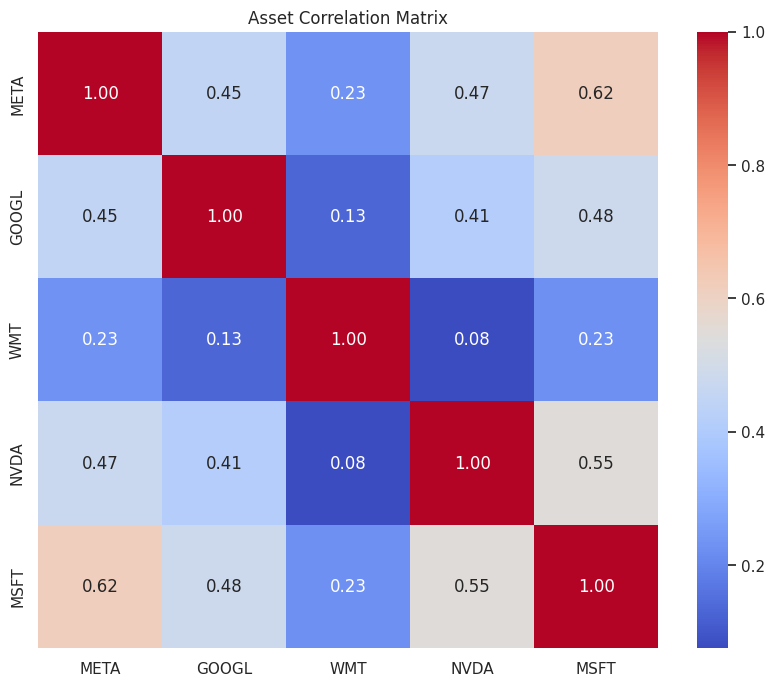

In [ ]:
# =============================================================================
# CORRELATION ANALYSIS
# =============================================================================

# 1. Calculate daily log returns for all tickers
returns = np.log(intro_data / intro_data.shift(1)).dropna()

# 2. Display the first few rows of returns
print("\nDaily Log Returns (first 5 rows):")
print(returns.head())

# 3. Compute correlation matrix
corr_matrix = returns.corr()

# 4. Display correlation matrix
print("\nCorrelation Matrix:")
print(corr_matrix)

# 5. Compute average pairwise correlation
avg_corr = corr_matrix.values[np.triu_indices_from(corr_matrix, k=1)].mean()
print(f"\nAverage pairwise correlation: {avg_corr:.2f}")

# 6. Visualize correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title("Asset Correlation Matrix")
plt.show()



The assets exhibit moderate co-movement. The average pairwise correlation is 0.36, indicating that while some assets tend to move in the same direction, they do not move perfectly together. For instance, tech stocks like META and MSFT show a relatively strong positive correlation (0.62), whereas WMT has very low correlations with most other assets, particularly NVDA (0.08). This suggests that while there is a tendency for some stocks to move together, especially within the same sector, others behave more independently.

The correlation structure directly impacts portfolio risk. Assets with higher positive correlations reduce diversification benefits, which can lead to higher overall portfolio volatility. Conversely, assets with low or near-zero correlations, such as WMT relative to the tech stocks, provide diversification that helps to lower total portfolio risk. Including such less correlated assets allows for constructing portfolios that maintain expected returns while mitigating volatility.

#### **Efficiency**


N-ASSET OPTIMIZATION: Max Sharpe (Train Set)

✓ Optimization successful

Optimal Weights:
  WMT: 61.64%
  NVDA: 21.59%
  META: 16.77%

Expected Performance:
  Annual Return: 52.18%
  Annual Volatility: 21.82%
  Sharpe Ratio: 2.300


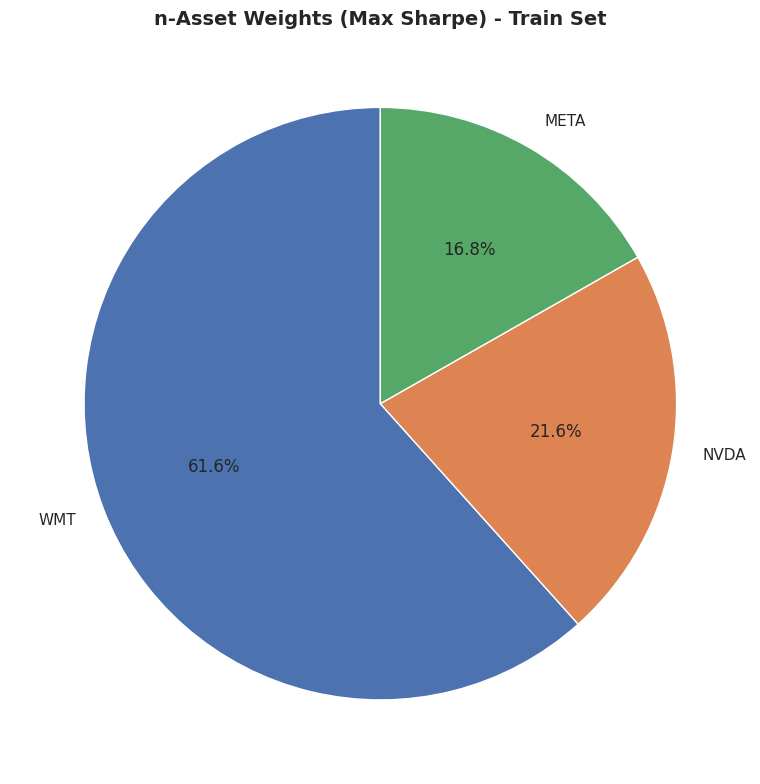


N-ASSET OPTIMIZATION: Min Volatility (Train Set)

✓ Optimization successful

Optimal Weights:
  WMT: 51.29%
  MSFT: 37.25%
  GOOGL: 11.46%

Expected Performance:
  Annual Return: 32.14%
  Annual Volatility: 17.07%
  Sharpe Ratio: 1.766


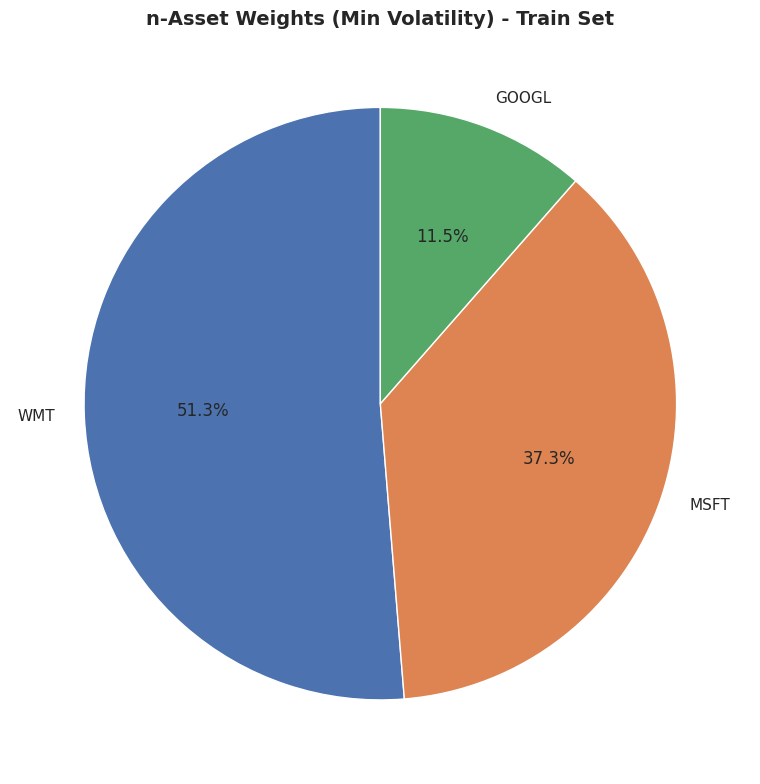


BACKTESTING (Out-of-Sample Test Set)
Test period: 2025-09-08 to 2025-11-26
Test days: 58

--- PERFORMANCE METRICS (Out-of-Sample) ---
                          Total Return  Annual Return  Annual Volatility  Sharpe Ratio  Max Drawdown  Calmar Ratio
Min Volatility (Train)           6.24%         31.33%             14.33%       218.58%        -4.11%       762.90%
Benchmark (Equal Weight)         4.71%         22.99%             16.53%       139.09%        -8.01%       287.06%
Max Sharpe (Train)               2.69%         12.70%             15.70%        80.91%        -6.96%       182.55%


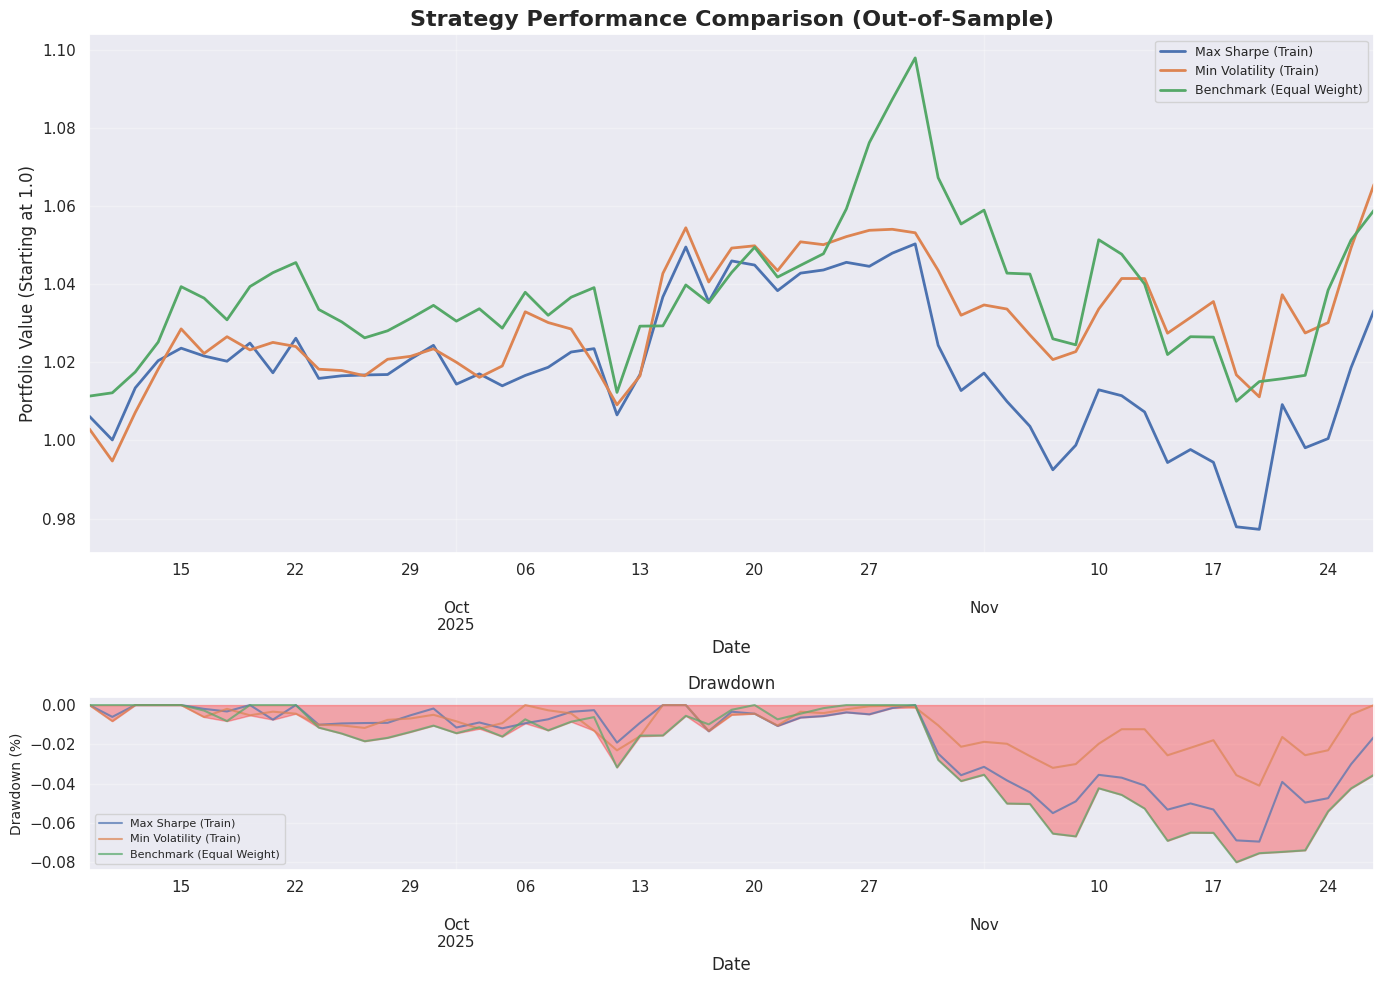


=== Out-of-Sample Performance Metrics ===
                          Total Return  Annual Return  Annual Volatility  Sharpe Ratio  Max Drawdown  Calmar Ratio
Min Volatility (Train)        0.062429       0.313259           0.143314      2.185829     -0.041062      7.628988
Benchmark (Equal Weight)      0.047052       0.229866           0.165260      1.390930     -0.080076      2.870582
Max Sharpe (Train)            0.026931       0.127031           0.157006      0.809086     -0.069587      1.825517

Best performing strategy on test set: Min Volatility (Train)


In [ ]:
weights_max_sharpe, perf_max_sharpe = optimize_n_assets(
    mu=portfolio_inputs['mu'],
    S=portfolio_inputs['S'],
    objective='max_sharpe',
    risk_free_rate=RISK_FREE_RATE,
    weight_bounds=(0,1)
)

weights_min_vol, perf_min_vol = optimize_n_assets(
    mu=portfolio_inputs['mu'],
    S=portfolio_inputs['S'],
    objective='min_volatility',
    risk_free_rate=RISK_FREE_RATE,
    weight_bounds=(0,1)
)



strategies_weights = {
    'Max Sharpe (Train)': weights_max_sharpe,
    'Min Volatility (Train)': weights_min_vol
}


cumulative_returns, metrics_df = backtest_all_strategies(
    test_data=test_data,
    strategies_weights=strategies_weights,
    tickers=all_tickers,
    risk_free_rate=RISK_FREE_RATE,
    initial_capital=1.0
)

# ==============================
# Print Metrics for Comparison
# ==============================
print("\n=== Out-of-Sample Performance Metrics ===")
print(metrics_df)

# ==============================
# Highlight Best Performing Strategy
# ==============================
best_strategy = metrics_df.index[0]
print(f"\nBest performing strategy on test set: {best_strategy}")


- The out-of-sample backtest reveals that the Min Volatility (Train) strategy was the best performing on the test set, outperforming both the Max Sharpe portfolio and the equal-weight benchmark. It achieved an annualized return of 31.33% with an annualized volatility of 14.33%, resulting in a remarkably high Sharpe ratio of 2.19. Compared to the Max Sharpe strategy, which delivered only 12.70% annualized return and a Sharpe ratio of 0.81, the Min Volatility portfolio demonstrated more stable and efficient performance over the 58-day test period. Its lower drawdown (-4.11%) also indicates superior risk management, emphasizing that portfolios optimized for low volatility may generalize better to unseen market conditions.

- On the training set, the Max Sharpe portfolio was expected to deliver the highest return (52.18%) and Sharpe ratio (2.30), while the Min Volatility portfolio had a lower expected return (32.14%) and Sharpe (1.77). However, the test set shows that the high-return, high-Sharpe Max Sharpe portfolio likely suffered from overfitting to historical data, whereas the Min Volatility strategy, being more conservative, maintained its risk-adjusted performance. This illustrates that strategies prioritizing robustness and lower risk can sometimes outperform theoretically “optimal” strategies when applied to new market conditions.

#### **Conclusion**

Based on the results of this study, historical optimization does not guarantee future success. Strategies optimized on past data may overfit to specific historical patterns, and market conditions can change, rendering them less effective. Out-of-sample testing and robust risk management are necessary to evaluate the potential real-world performance of any optimized portfolio.
